In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
from numpy import random

#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('/users/ganeshmakkina/desktop/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [7]:
#select relevant countries and merge with leagues

selected_countries = ['England','France','Germany','Italy','Spain']

countries = countries[countries.name.isin(selected_countries)]

leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_92865/1740956630.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'name_y'} in the result is deprecated and will raise a MergeError in a future version.
  leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))


In [8]:
#select relevant fields

matches = matches[matches.league_id.isin(leagues.id)]

matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

matches.dropna(inplace=True)

matches.head()

id  country_id  league_id     season  stage                 date  \
1728  1729        1729       1729  2008/2009      1  2008-08-17 00:00:00   
1729  1730        1729       1729  2008/2009      1  2008-08-16 00:00:00   
1730  1731        1729       1729  2008/2009      1  2008-08-16 00:00:00   
1731  1732        1729       1729  2008/2009      1  2008-08-16 00:00:00   
1732  1733        1729       1729  2008/2009      1  2008-08-17 00:00:00   

      match_api_id  home_team_api_id  away_team_api_id  B365H  B365D  B365A  
1728        489042             10260             10261   1.29    5.5  11.00  
1729        489043              9825              8659   1.20    6.5  15.00  
1730        489044              8472              8650   5.50    3.6   1.67  
1731        489045              8654              8528   1.91    3.4   4.20  
1732        489046             10252              8456   1.91    3.4   4.33

In [9]:
from scipy.stats import entropy



def match_entropy(row):

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #change odds to probability

    probs = [1/o for o in odds]

    #normalize to sum to 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)



#compute match entropy

matches['entropy'] = matches.apply(match_entropy,axis=1)


In [11]:
#compute mean entropy for every league in every season

#entropy_means = matches.groupby(('season','league_id')).entropy.mean()
entropy_means = matches.groupby(['season', 'league_id']).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]

entropy_means.head(10)

England    France   Germany     Italy     Spain
season                                                     
2008/2009  0.984556  1.026638  1.004276  1.002201  1.010859
2009/2010  0.956496  1.013821  0.997925  1.006755  0.977810
2010/2011  0.983258  1.026236  1.016264  1.006029  0.975032
2011/2012  0.969593  1.024915  1.001298  1.003077  0.955339
2012/2013  0.981472  1.016116  0.993993  1.003565  0.970580
2013/2014  0.960473  1.004439  0.977500  0.992622  0.944218
2014/2015  0.980301  1.012495  0.985835  0.999100  0.933637
2015/2016  0.997819  1.013928  0.974657  0.985284  0.946813

Text(7.3, 0.952, 'more predictable')

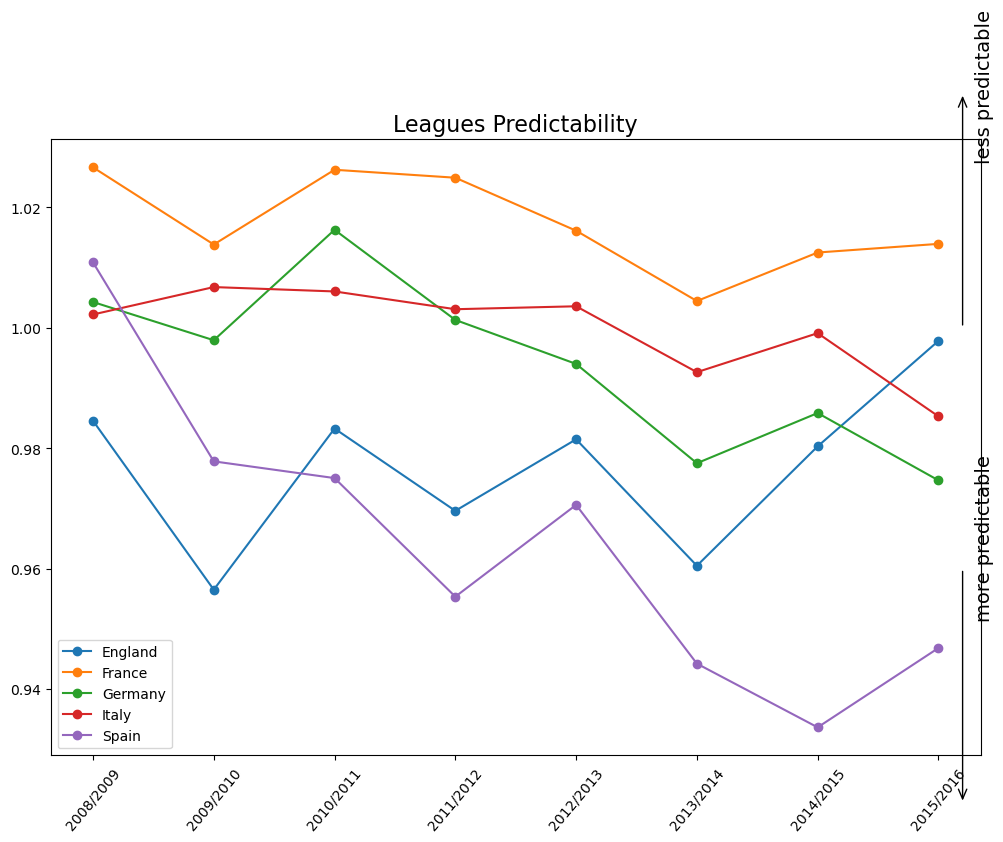

In [12]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

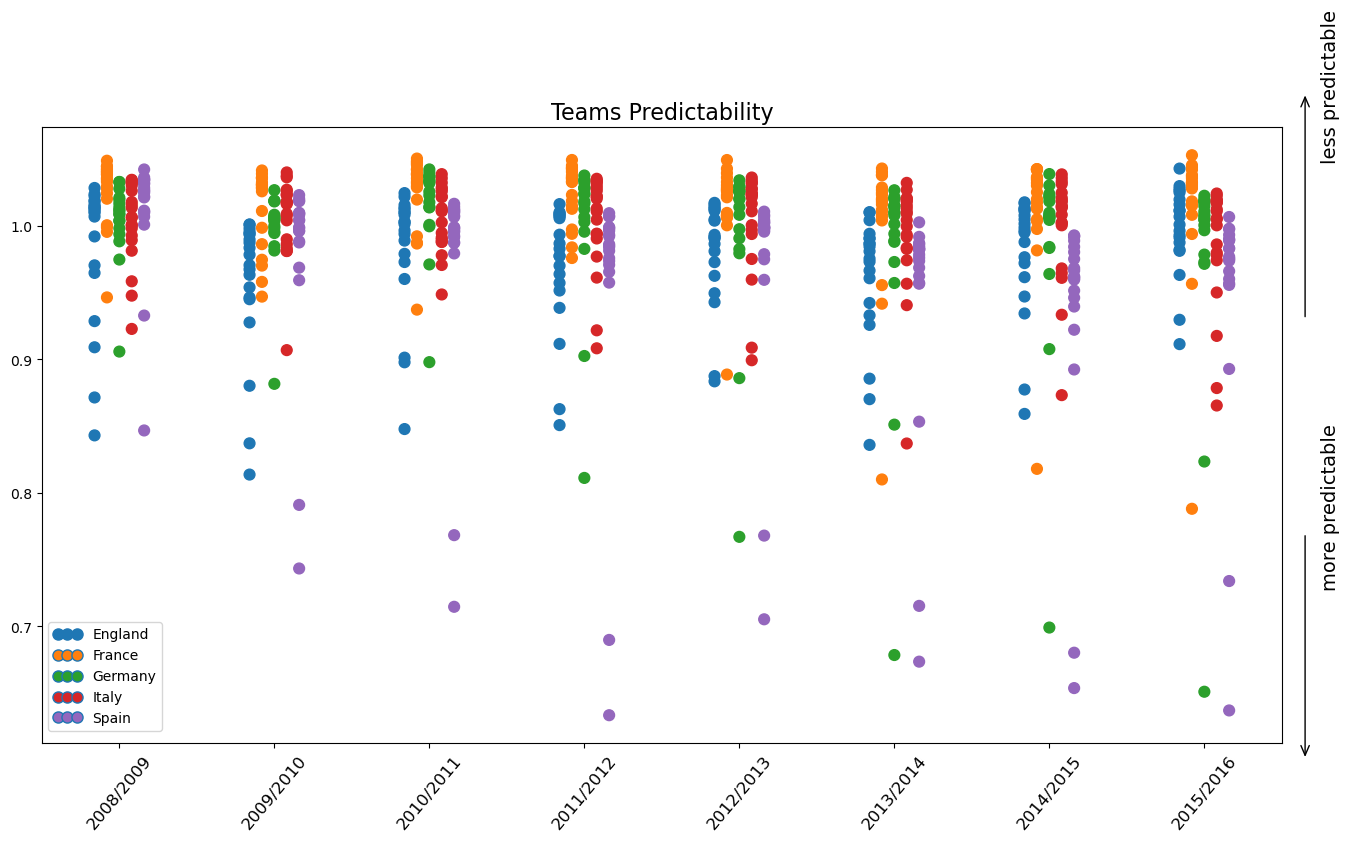

In [14]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

barcelona = teams[teams.team_long_name=='Barcelona'].team_api_id.values
if len(barcelona) > 0:
    barcelona = barcelona[0]
else:
    barcelona = None

offsets = [-0.16, -0.08, 0, 0.08, 0.16]
offsets_mapping = dict(zip(colors_mapping.keys(), offsets))
y = []
x = []
c = []

for i, (season, season_df) in enumerate(matches.groupby('season')):
    for team, name in zip(teams.team_api_id, teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id == team) | (season_df.away_team_api_id == team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy > 0:
            league_id = team_df.league_id.values[0]
            x.append(i + offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])

plt.figure(figsize=(16, 8))
plt.scatter(x, y, color=c, s=[60] * len(x))
plt.title('Teams Predictability', fontsize=16)

#create ticks and labels
ax = plt.gca()
plt.xlim((-0.5, 7.5))
plt.xticks(np.arange(0, 8, 1), rotation=50)

#create grid
ax.set_xticklabels(entropy_means.index, fontsize=12)
for i in range(7):
    ax.axvline(x=0.5 + i, ls='--', c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

#create legend
circles = []
labels = []
for league_id, name in zip(leagues.id, leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005, 0.02))

#add arrows
ax.annotate('', xytext=(7.65, 0.93), xy=(7.65, 1.1),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3", linewidth=1),
            annotation_clip=False)

ax.annotate('', xytext=(7.65, 0.77), xy=(7.65, 0.6),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3", linewidth=1),
            annotation_clip=False)

ax.annotate('less predictable', xy=(7.75, 1.05), annotation_clip=False, fontsize=14, rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.73), annotation_clip=False, fontsize=14, rotation='vertical')

#add labels
if barcelona:
    ax.annotate('Barcelona', xy=(6.55, 0.634), fontsize=9)
    ax.annotate('B. Munich', xy=(6.5, 0.655), fontsize=9)
    ax.annotate('Real Madrid', xy=(6.51, 0.731), fontsize=9)
    ax.annotate('PSG', xy=(6.93, 0.78), fontsize=9)

plt.show()


In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
from numpy import random

#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('/users/ganeshmakkina/desktop/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    Player_detail = pd.read_sql_query("SELECT * from Player_Attributes", con)
    Player = pd.read_sql_query("SELECT * from Player", con)
    

sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
Player_detail.shape

(183978, 42)

In [18]:
Player_detail.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0       44.0              71.0           61.0     44.0       51.0   45.0   
1       44.0              71.0           61.0     44.0       51.0   45.0   
2       44.0              71.0           61.0     44.0       51.0   45.0   
3       43.0              70.0           60.0     43.0       50.0   44.0   
4       43.0              70.0           60.0     43.0       50.0   44.0   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                39.0          64.0          49.0          60.0          64.0   
1                39.0          64.0          49.0          60.0          64.0   
2                39.0          64.0          49.0          60.0          64.0   
3                38.0          63.0          48.0          60.0          64.0   
4                38.0          63.0          48.0          60.0          64.0   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
1     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
2     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
3     59.0       46.0     65.0        54.0     58.0     54.0      76.0   
4     59.0       46.0     65.0        54.0     58.0     54.0      76.0   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0        35.0        71.0           70.0         45.0    54.0       48.0   
1        35.0        71.0           70.0         45.0    54.0       48.0   
2        35.0        63.0           41.0         45.0    54.0       48.0   
3        34.0        62.0           40.0         44.0    53.0       47.0   
4        34.0        62.0           40.0         44.0    53.0       47.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   
3     62.0             63.0            66.0        5.0         10.0   
4     62.0             63.0            66.0        5.0         10.0   

   gk_kicking  gk_positioning  gk_reflexes  
0        10.0             8.0          8.0  
1        10.0             8.0          8.0  
2        10.0             8.0          8.0  
3         9.0             7.0          7.0  
4         9.0             7.0          7.0

<Axes: xlabel='potential', ylabel='Count'>

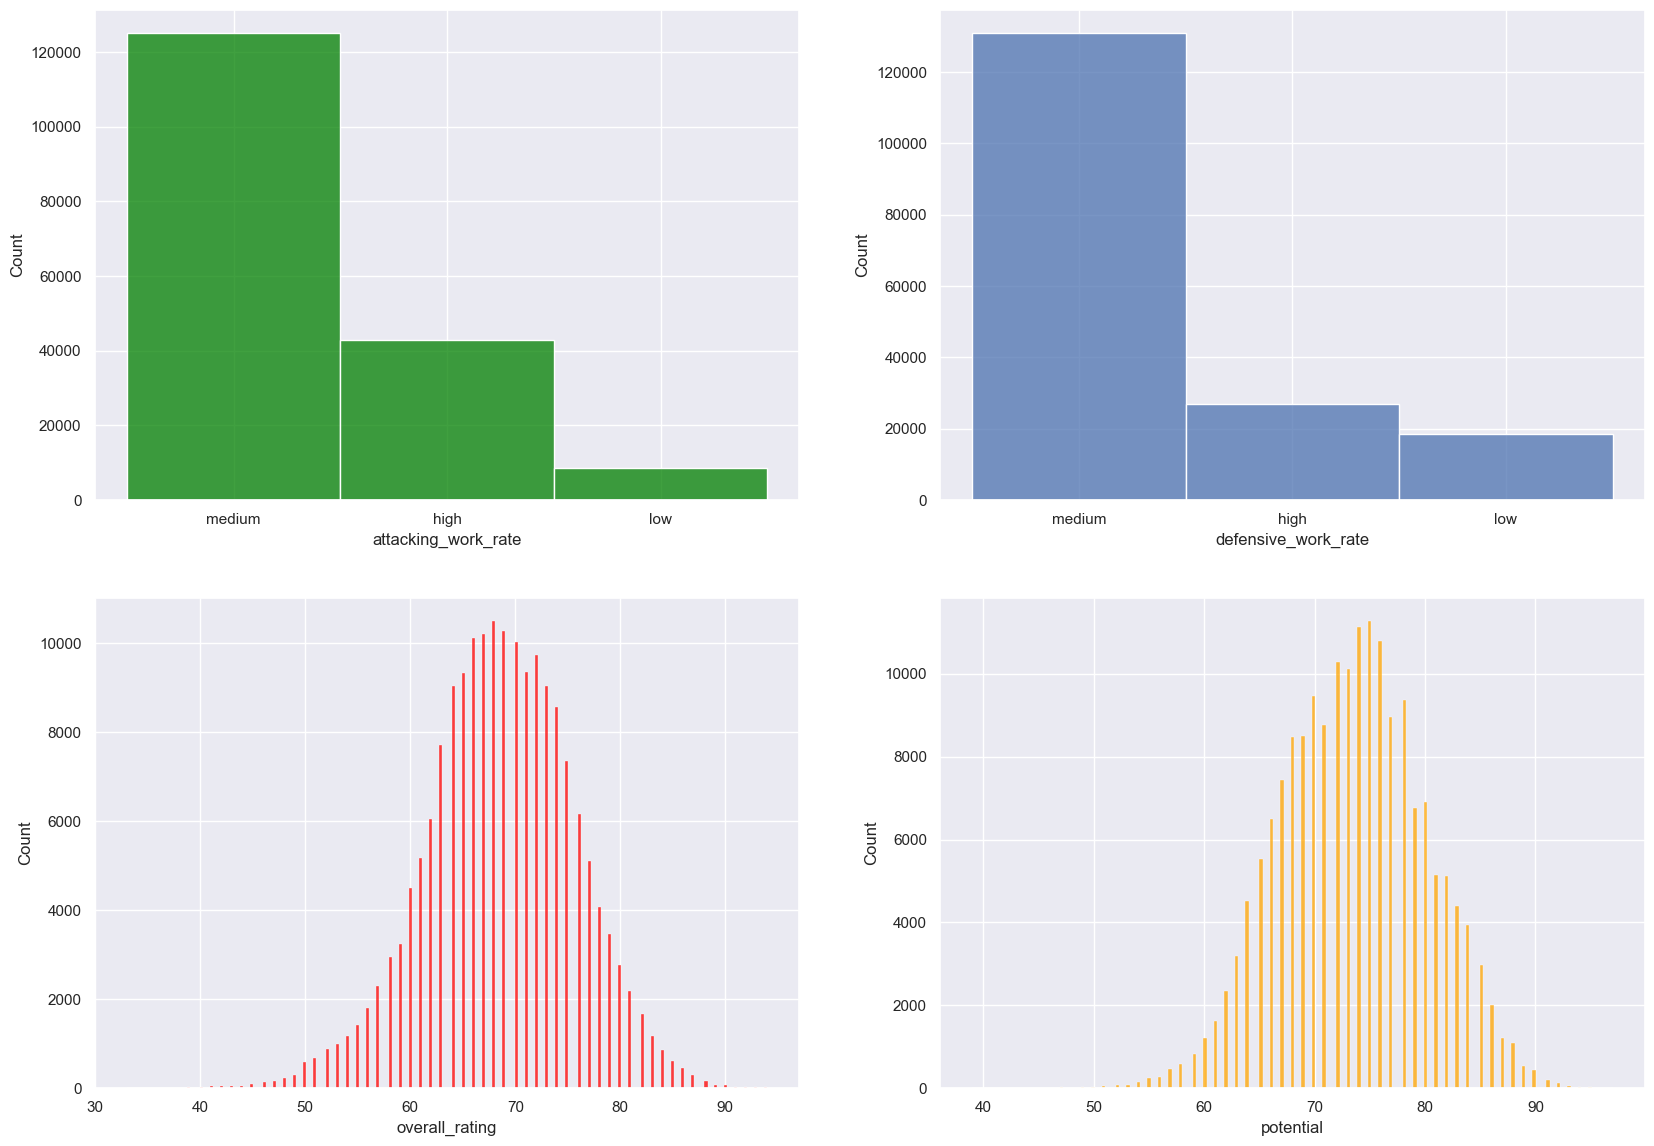

In [19]:
fig ,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,14))

attack_work_rate = Player_detail[Player_detail['attacking_work_rate'].isin(['medium','high','low'])]
defence_work_rate = Player_detail[Player_detail['defensive_work_rate'].isin(['medium','high','low'])]


sns.histplot(attack_work_rate['attacking_work_rate'],ax=axes[0,0],color='green')
sns.histplot(defence_work_rate['defensive_work_rate'],ax=axes[0,1])
sns.histplot(Player_detail['overall_rating'],ax=axes[1,0],color='red')
sns.histplot(Player_detail['potential'],ax=axes[1,1],color='orange')

In [20]:
Player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

Player data contains personal information such as "player_name".

Player_detail and Player data are joined using "player_api_id".

In [21]:
Players = pd.merge(Player_detail,Player,on='player_api_id',how='left')

In [22]:
print(Player.shape)
print(Player_detail.shape)
print(Players.shape)

(11060, 7)
(183978, 42)
(183978, 48)


Using the joined data, we will check the ratings using the data of the most recent Ballon d'Or award winner and Kagawa, the most highly rated Japanese player!

In [23]:
ballondr = Players[Players['player_name'].isin(['Lionel Messi','Cristiano Ronaldo','Luka Modric','Shinji Kagawa'])]
ballondr.head()

id_x  player_fifa_api_id_x  player_api_id                 date  \
33330  33331                 20801          30893  2015-10-16 00:00:00   
33331  33332                 20801          30893  2015-09-25 00:00:00   
33332  33333                 20801          30893  2015-09-21 00:00:00   
33333  33334                 20801          30893  2015-05-15 00:00:00   
33334  33335                 20801          30893  2015-04-17 00:00:00   

       overall_rating  potential preferred_foot attacking_work_rate  \
33330            93.0       93.0          right                high   
33331            93.0       93.0          right                high   
33332            93.0       93.0          right                high   
33333            92.0       92.0          right                high   
33334            92.0       92.0          right                high   

      defensive_work_rate  crossing  finishing  heading_accuracy  \
33330                 low      82.0       95.0              86.0   
33331                 low      82.0       95.0              86.0   
33332                 low      82.0       95.0              86.0   
33333                 low      83.0       95.0              86.0   
33334                 low      83.0       95.0              86.0   

       short_passing  volleys  dribbling  curve  free_kick_accuracy  \
33330           81.0     87.0       93.0   88.0                77.0   
33331           81.0     87.0       93.0   88.0                77.0   
33332           81.0     87.0       93.0   88.0                77.0   
33333           82.0     87.0       93.0   88.0                79.0   
33334           82.0     87.0       93.0   88.0                79.0   

       long_passing  ball_control  acceleration  sprint_speed  agility  \
33330          72.0          91.0          91.0          93.0     90.0   
33331          72.0          91.0          91.0          93.0     90.0   
33332          72.0          91.0          91.0          93.0     90.0   
33333          72.0          92.0          91.0          94.0     93.0   
33334          72.0          92.0          91.0          94.0     93.0   

       reactions  balance  shot_power  jumping  stamina  strength  long_shots  \
33330       92.0     62.0        94.0     94.0     90.0      79.0        93.0   
33331       92.0     62.0        94.0     94.0     87.0      79.0        93.0   
33332       92.0     62.0        94.0     94.0     87.0      79.0        93.0   
33333       90.0     63.0        94.0     94.0     89.0      79.0        93.0   
33334       90.0     63.0        94.0     94.0     89.0      79.0        93.0   

       aggression  interceptions  positioning  vision  penalties  marking  \
33330        62.0           29.0         93.0    81.0       85.0     22.0   
33331        62.0           29.0         93.0    81.0       85.0     22.0   
33332        62.0           29.0         93.0    81.0       85.0     22.0   
33333        63.0           24.0         91.0    81.0       85.0     22.0   
33334        63.0           24.0         91.0    81.0       85.0     22.0   

       standing_tackle  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
33330             31.0            23.0        7.0         11.0        15.0   
33331             31.0            23.0        7.0         11.0        15.0   
33332             31.0            23.0        7.0         11.0        15.0   
33333             31.0            23.0        7.0         11.0        15.0   
33334             31.0            23.0        7.0         11.0        15.0   

       gk_positioning  gk_reflexes  id_y        player_name  \
33330            14.0         11.0  1995  Cristiano Ronaldo   
33331            14.0         11.0  1995  Cristiano Ronaldo   
33332            14.0         11.0  1995  Cristiano Ronaldo   
33333            14.0         11.0  1995  Cristiano Ronaldo   
33334            14.0         11.0  1995  Cristiano Ronaldo   

       player_fifa_api_id_y             birthday  height 

In [24]:
overall = ballondr[['overall_rating','player_name']].groupby('player_name').mean()
overall

overall_rating
player_name                      
Cristiano Ronaldo       91.280000
Lionel Messi            92.192308
Luka Modric             83.125000
Shinji Kagawa           81.700000

In [25]:
Players['overall_rating'].describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

Looking at the "overall_rating" of all players, we see that the average is 68.6



Next, let's check the rating of Japanese players in Europe at each age.

First, we extract the players and use "date" and "birthday" to determine their age at the time of rating.

In [26]:
from datetime import date

japan = Players[Players['player_name'].isin(['Shinji Kagawa','Atsuto Uchida','Maya Yoshida','Keisuke Honda','Makoto Hasebe','Yuto Nagatomo'])]
japan[['date','birthday']] = japan[['date','birthday']].apply(pd.to_datetime)
japan['age'] = (japan['date'] - japan['birthday']).dt.days // 365
japan = japan[japan['age']>20]
japan.head()

/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_92865/3665370415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japan[['date','birthday']] = japan[['date','birthday']].apply(pd.to_datetime)
/var/folders/mp/_dpx4t9n1pd1gr7w1dys6jn80000gn/T/ipykernel_92865/3665370415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japan['age'] = (japan['date'] - japan['birthday']).dt.days // 365


id_x  player_fifa_api_id_x  player_api_id       date  overall_rating  \
17942  17943                191541          72813 2016-04-07            76.0   
17943  17944                191541          72813 2016-03-31            76.0   
17944  17945                191541          72813 2015-09-21            76.0   
17945  17946                191541          72813 2015-02-20            76.0   
17946  17947                191541          72813 2015-02-06            75.0   

       potential preferred_foot attacking_work_rate defensive_work_rate  \
17942       76.0          right                high              medium   
17943       76.0          right                high              medium   
17944       77.0          right                high              medium   
17945       77.0          right                high              medium   
17946       77.0          right                high              medium   

       crossing  finishing  heading_accuracy  short_passing  volleys  \
17942      76.0       36.0              61.0           77.0     34.0   
17943      76.0       36.0              61.0           77.0     34.0   
17944      76.0       36.0              61.0           77.0     34.0   
17945      76.0       45.0              60.0           77.0     59.0   
17946      77.0       45.0              60.0           77.0     59.0   

       dribbling  curve  free_kick_accuracy  long_passing  ball_control  \
17942       75.0   68.0                36.0          75.0          77.0   
17943       75.0   68.0                36.0          75.0          77.0   
17944       75.0   68.0                36.0          75.0          77.0   
17945       74.0   67.0                44.0          74.0          77.0   
17946       74.0   67.0                44.0          74.0          77.0   

       acceleration  sprint_speed  agility  reactions  balance  shot_power  \
17942          77.0          78.0     77.0       76.0     75.0        68.0   
17943          77.0          78.0     77.0       76.0     75.0        68.0   
17944          77.0          78.0     77.0       76.0     75.0        68.0   
17945          77.0          78.0     79.0       76.0     75.0        67.0   
17946          77.0          78.0     79.0       76.0     75.0        67.0   

       jumping  stamina  strength  long_shots  aggression  interceptions  \
17942     72.0     81.0      50.0        49.0        65.0           76.0   
17943     72.0     83.0      50.0        49.0        65.0           76.0   
17944     72.0     83.0      50.0        49.0        65.0           76.0   
17945     72.0     83.0      51.0        48.0        61.0           75.0   
17946     72.0     83.0      51.0        48.0        61.0           75.0   

       positioning  vision  penalties  marking  standing_tackle  \
17942         72.0    65.0       41.0     76.0             74.0   
17943         72.0    65.0       41.0     76.0             74.0   
17944         72.0    65.0       41.0     76.0             74.0   
17945         71.0    64.0       40.0     72.0             75.0   
17946         72.0    64.0       40.0     72.0             75.0   

       sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
17942            78.0       10.0         13.0        16.0            15.0   
17943            78.0       10.0         13.0        16.0            15.0   
17944            78.0       10.0         13.0        16.0            15.0   
17945            78.0        9.0         12.0        15.0            14.0   
17946            78.0        9.0         12.0        15.0            14.0   

       gk_reflexes  id_y    player_name  player_fifa_api_id_y   birthday  \
17942         16.0  1042  Atsuto Uchida                191541 1988-03-27   
17943         16.0  1042  Atsuto Uchida                191541 1988-03-27   
17944         16.0  1042  Atsuto Uchida                191541 1988-03-27   
17945         15.0  1042  Atsuto Uchida                191541 1988-03-27   
17946         15.0  

Next, the average values by age and name are calculated,
Then, we visualize the evaluation transition by age and name!

In [27]:
japan_rate = japan[['player_name','age','overall_rating']].groupby(['age','player_name']).mean().unstack()
japan_rate.columns = ['Atsuto Uchida','Keisuke Honda','Makoto Hasebe','Maya Yoshida','Shinji Kagawa','Yuto Nagatomo']
japan_rate

Atsuto Uchida  Keisuke Honda  Makoto Hasebe  Maya Yoshida  Shinji Kagawa  \
age                                                                             
21             NaN            NaN            NaN           NaN           75.5   
22       72.500000            NaN            NaN     62.500000           82.0   
23       72.500000      77.500000          63.00     64.500000           83.0   
24       73.750000      80.000000          66.50     71.142857           82.4   
25       73.416667      81.000000          72.50     71.250000           82.8   
26       74.363636      81.000000          75.00     71.200000           82.0   
27       76.000000      80.066667          74.50     72.666667           82.0   
28       76.000000      77.857143          73.50           NaN            NaN   
29             NaN      76.875000          74.75           NaN            NaN   
30             NaN            NaN          74.00           NaN            NaN   
31             NaN            NaN          75.00           NaN            NaN   
32             NaN            NaN          74.00           NaN            NaN   

     Yuto Nagatomo  
age                 
21             NaN  
22             NaN  
23       67.000000  
24       75.500000  
25       77.500000  
26       78.333333  
27       77.000000  
28       74.307692  
29       73.555556  
30             NaN  
31             NaN  
32             NaN

Text(0.5, 0, 'age')

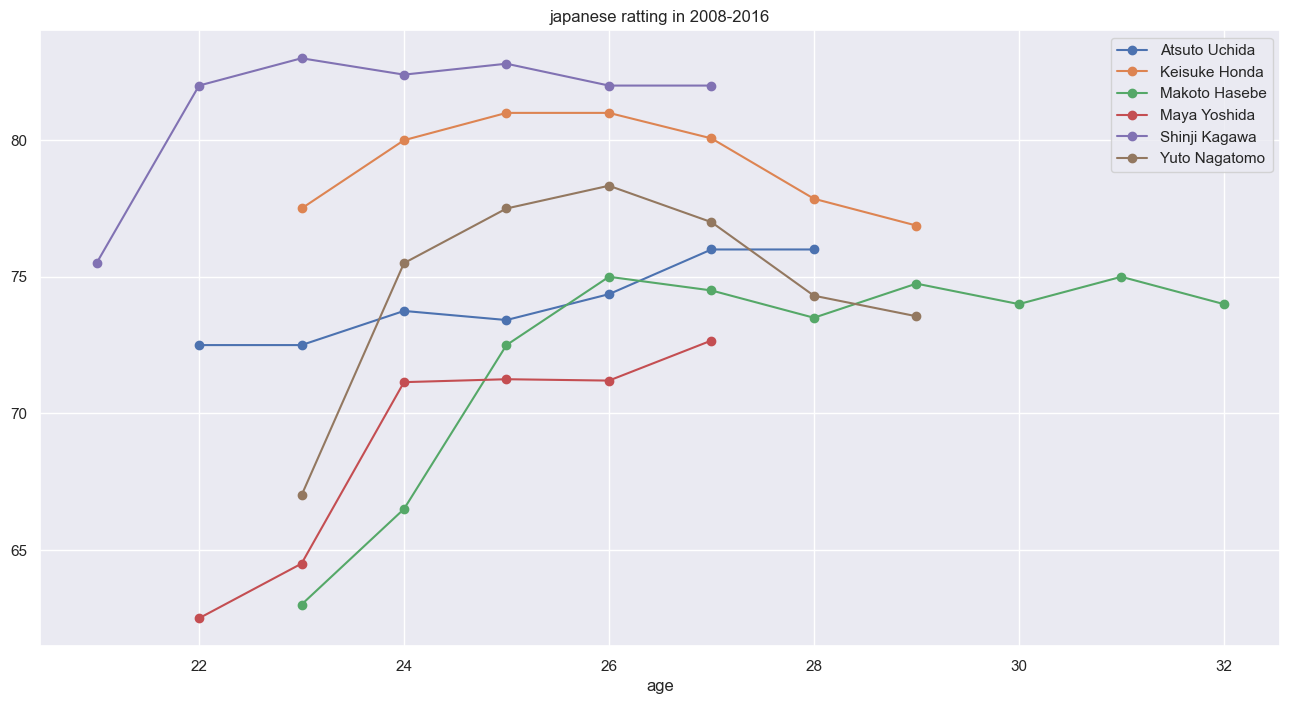

In [28]:
ax = japan_rate.plot(figsize=(16,8),marker='o')
plt.title("japanese ratting in 2008-2016")

plt.xlabel("age")

Visualization shows that the players are highly rated between the ages of 26-28, and after that, they are either low or flat.



**In order for Japanese players to be successful in Europe, one of the keys may be to move to a new country when they are between 26 and 28 years old.**


From here, we will perform classification by clustering.

For this classification of players, we will try to classify a total of 33 players selected for the World Cup in Brazil in 2014, 11 each from the national teams of Japan, Spain, and Germany!

First, excerpt each national player and aggregate data about when that player received the highest rating.



In [30]:
#Japan national soccer team
japan = Players[Players['player_name'].isin(['Shinji Kagawa','Atsuto Uchida','Maya Yoshida','Keisuke Honda','Makoto Hasebe','Yuto Nagatomo','Gotoku Sakai','Hiroki Sakai','Shinji Okazaki','Hiroshi Kiyotake','Yuya Osako'])]
japan_max_ratio = japan[['player_name','overall_rating']].groupby('player_name').max()
japan_max_ratio['max'] = 1
japan = pd.merge(japan,japan_max_ratio,on=['player_name','overall_rating'],how='inner')
japan = japan.drop_duplicates(subset=['player_name']).reset_index(drop=True)
japan['country'] = 'japan'

In [31]:
#Spain national soccer team
spain = Players[Players['player_name'].isin(['Gerard Pique','Sergio Ramos','Sergio Busquets','Xavi Hernandez','Andres Iniesta','David Silva','Fernando Torres','David Villa','Juan Mata','Jordi Alba','Cesc Fabregas'])]
spain_max_ratio = spain[['player_name','overall_rating']].groupby('player_name').max()
spain_max_ratio['max'] = 1
spain = pd.merge(spain,spain_max_ratio,on=['player_name','overall_rating'],how='inner')
spain = spain.drop_duplicates(subset=['player_name']).reset_index(drop=True)
spain['country'] = 'spain'

In [32]:
#Germany national soccer team
germany = Players[Players['player_name'].isin(['Mats Hummels','Jerome Boateng','Shkodran Mustafi','Philipp Lahm','Bastian Schweinsteiger','Toni Kroos','Mesut Oezil','Lukas Podolski','Miroslav Klose','Sami Khedira','Julian Draxler'])]
germany_max_ratio = germany[['player_name','overall_rating']].groupby('player_name').max()
germany_max_ratio['max'] = 1
germany = pd.merge(germany,germany_max_ratio,on=['player_name','overall_rating'],how='inner')
germany = germany.drop_duplicates(subset=['player_name']).reset_index(drop=True)
germany['country'] = 'germany'

In [33]:
#Union the data of representative athletes from the three countries into a single data set.
#Also, designate athlete names as indexes, ready for clustering
countries_player = pd.concat([japan,spain,germany],axis=0)
countries_player = countries_player[['player_name','overall_rating', 'potential','crossing', 'finishing','heading_accuracy',
                                    'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
                                    'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
                                    'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
                                    'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
                                    'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle','height', 'weight']]
countries_player = countries_player.reset_index(drop=True)
countries_player = countries_player.set_index('player_name')
countries_player.shape

(33, 32)

In [34]:
from sklearn import preprocessing

countries_player_scale = preprocessing.scale(countries_player)

countries_player_scale = pd.DataFrame(countries_player_scale)
countries_player_scale.columns = countries_player.columns
countries_player_scale.index = countries_player.index
countries_player_scale.head()

overall_rating  potential  crossing  finishing  \
player_name                                                        
Atsuto Uchida          -1.318013  -1.573145  0.328148  -1.639974   
Gotoku Sakai           -1.670195  -1.233839  0.398012  -1.413297   
Hiroki Sakai           -2.022376  -1.912451 -0.300626  -1.809982   
Hiroshi Kiyotake       -1.141922  -1.064186  0.817195  -0.053235   
Keisuke Honda          -0.437559  -0.385575  0.328148   0.456789   

                  heading_accuracy  short_passing   volleys  dribbling  \
player_name                                                              
Atsuto Uchida            -0.475125      -0.548366 -2.279341  -0.129295   
Gotoku Sakai             -0.622346      -0.674033 -2.012373  -0.129295   
Hiroki Sakai              0.113762      -1.176701 -1.812147  -1.195983   
Hiroshi Kiyotake         -2.389007      -0.171364  0.390340   0.161619   
Keisuke Honda             0.040151      -0.171364  0.323598   0.452534   

                     curve  free_kick_accuracy  long_passing  ball_control  \
player_name                                                                  
Atsuto Uchida    -0.374834           -1.811637      0.124091     -0.556758   
Gotoku Sakai     -0.040523           -0.101713     -0.511340     -0.950465   
Hiroki Sakai     -0.040523           -0.608357     -0.864358     -1.737880   
Hiroshi Kiyotake  1.045989            1.354889      0.547712     -0.294286   
Keisuke Honda     1.463878            1.418220      0.265298      0.755600   

                  acceleration  sprint_speed   agility  reactions   balance  \
player_name                                                                   
Atsuto Uchida         0.135795      0.493517 -0.022432  -1.317395  0.082499   
Gotoku Sakai          0.135795      0.493517  0.070101  -1.494840  0.482859   
Hiroki Sakai          0.042436      0.298475 -0.485098  -1.849730 -0.638150   
Hiroshi Kiyotake      0.042436     -0.481696  0.902900  -0.430170  0.803147   
Keisuke Honda         0.229154      0.395996  0.347701  -1.317395 -0.638150   

                  shot_power   jumping   stamina  strength  long_shots  \
player_name                                                              
Atsuto Uchida      -0.433620 -0.025959  0.325343 -1.386712   -1.329648   
Gotoku Sakai       -1.101395 -0.311504  0.066636 -0.378408   -1.838173   
Hiroki Sakai       -0.338224 -1.263324 -0.192070  0.086963   -0.675831   
Hiroshi Kiyotake    0.234155 -0.406686 -1.744307 -1.696960    0.413864   
Keisuke Honda       1.283516  0.640315  0.325343  0.009401    1.067681   

                  aggression  interceptions  positioning    vision  penalties  \
player_name                                                                     
Atsuto Uchida      -0.006131       0.384715    -0.043955 -1.021670  -1.927276   
Gotoku Sakai        0.196202       0.384715    -0.624156 -1.442058  -1.376285   
Hiroki Sakai        0.533425      -0.167268    -0.769207 -1.442058  -2.320841   
Hiroshi Kiyotake   -2.501577      -1.672675    -0.261530  0.239494   0.040549   
Keisuke Honda      -0.141020      -0.719250     0.391197 -0.096817   0.512827   

                   marking  standing_tackle  sliding_tackle    height  \
player_name                                                             
Atsuto Uchida     0.793031         0.521348        0.730220 -0.664863   
Gotoku Sakai      0.514203         0.521348        0.613620 -0.664863   
Hiroki Sakai      0.713366         0.440953        0.691353  0.750651   
Hiroshi Kiyotake -1.318097        -1.488520       -1.251974 -1.018741   
Keisuke Honda     0.155709         0.159571        0.186088  0.396773   

                    weight  
player_name                 
Atsuto Uchida    -0.722302  
Gotoku Sakai     -0.165098  
Hiroki Sakai     -0.041274  
Hiroshi Kiyotake -1.217595  
Keisuke Honda     0.144460

[Non-Hierarchical Clustering]
From here, we will use KMeans for non-hierarchical clustering!

K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms.

The algorithm starts by randomly initializing some predefined number of centroids (n_clusters), and It then iterates through the following two processes.

Assign a point to the nearest cluster centroid
Move each centroid to minimize the distance to that point.
→ Repeat these two steps until the centroid stops moving or a certain maximum number of iterations (max_iter) has elapsed. The centroid is defined where the total distance of each point is minimized from the clustering centroid where the total distance between each point and its center of gravity is minimized.

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Vec = KMeans(n_clusters=3)
group_num = Vec.fit_predict(countries_player_scale)

[Finding the optimal number of clusters]
Checking the elbow curve to obtain the appropriate number of clusters
A fundamental step in unsupervised algorithms is to determine the optimal number of clusters in which the data will be clustered.
The Elbow method is one of the most common methods to determine this optimal value of k.

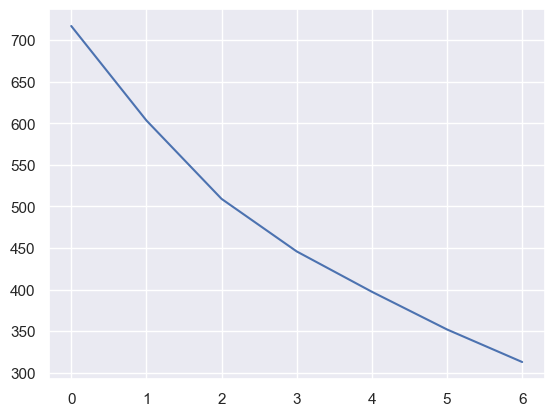

In [36]:
sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(countries_player_scale)
    
    sse.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(sse)

**This figure is called the elbow diagram**
The vertical axis is the SSE and the horizontal axis is the number of clusters.
**Sum of Squared Error** (SSE: Sum of Squared Error) is the sum of the squared values of the difference between the predicted value and the correct value (=error) for each data.
In other words, it shows the number of clusters when the distance from the centroid is minimized.
The optimal number of clusters is the one at which the line graph goes sideways and the clusters are broken.

**What is inertia?**

A measure of the squared error within each cluster that should be minimized in the optimization of kmeans.

It assumes convex and isotropic surfaces, and is not suited to dealing with sets that combine irregular structures, such as long and narrow sets.
Since it is not a normalized index, it cannot say more than "lower is better and 0 is optimal.

**Silhouette Analysis**

Silhouette Analysis can evaluate the results of clustering.
A silhouette plot shows how close each point in one cluster is to any point in a neighboring cluster,
A visual way to evaluate parameters such as the number of clusters.
The range of this evaluation is [-1, 1].

A silhouette coefficient close to +1 indicates that the sample is far away from the neighboring clusters and that the separation performance of the clustering is good.
A value of 0 indicates that the sample is at or very close to the decision boundary between two adjacent clusters, indicating poor separation performance.
A negative value indicates that the clustered sample may belong to the wrong cluster, and the goal is to be as close to 1 as possible.

Since this index evaluates the degree of separation, it scores higher when the number of clusters is low.

Silhouette score = p-qmax(p,q)

p is the average distance to the point in the nearest cluster to which the data point does not belong

q is the average intra-cluster distance to all points in its own cluster

In [37]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(countries_player_scale)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(countries_player_scale, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.2652887222262509
For n_clusters=3, the silhouette score is 0.21981529403076377
For n_clusters=4, the silhouette score is 0.199734370566589
For n_clusters=5, the silhouette score is 0.18472630173867888
For n_clusters=6, the silhouette score is 0.19453835920878493
For n_clusters=7, the silhouette score is 0.19822878965283391
For n_clusters=8, the silhouette score is 0.1984493091997274


In [38]:
player_clus = countries_player_scale.copy()
player_clus['group'] = group_num

player_clus = player_clus[['overall_rating','finishing','short_passing','free_kick_accuracy',
                           'height','weight','positioning','agility','dribbling','heading_accuracy','group']].groupby('group').mean()
player_clus = player_clus.T
player_clus

group                      0         1         2
overall_rating      0.040402  0.530940 -0.877786
finishing          -0.757553  0.779095 -0.716265
short_passing      -0.350889  0.527659 -0.598632
free_kick_accuracy -1.078812  0.808664 -0.538693
height              1.256192 -0.266749 -0.452536
weight              1.303092 -0.261835 -0.493229
positioning        -1.245801  0.740224 -0.312298
agility            -1.463307  0.411317  0.366207
dribbling          -1.320661  0.761631 -0.294147
heading_accuracy    0.997092 -0.401514 -0.055543

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

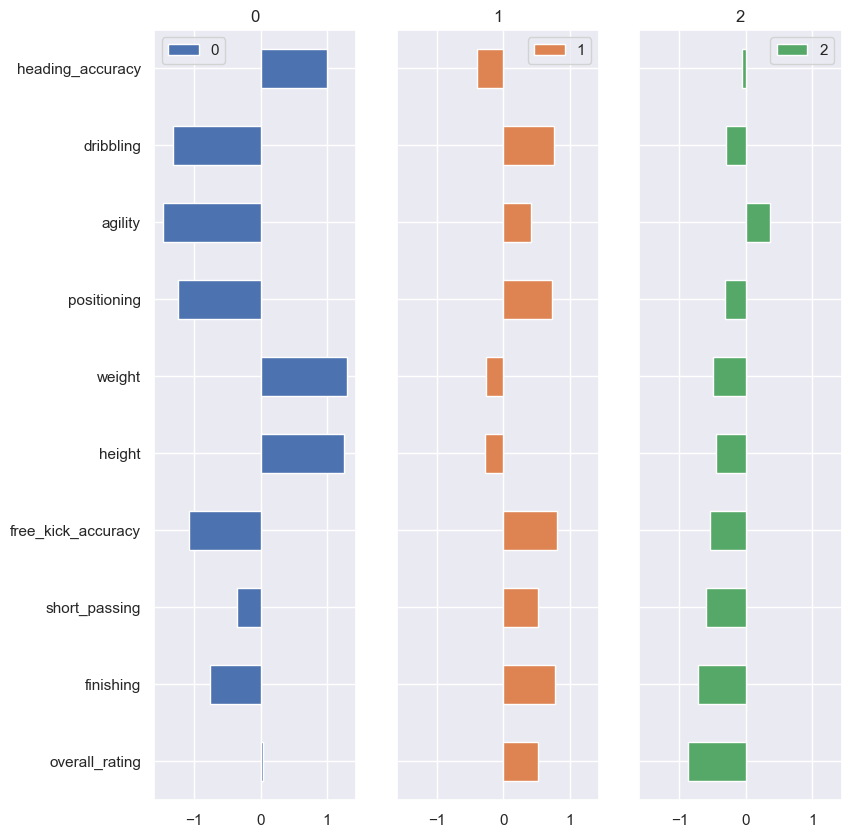

In [39]:
player_clus[0:].plot(figsize=(12,10),kind='barh',subplots=True,layout=(1,4),sharey=True)

The following groupings may be made from the three categories

Group 0
excels in weight, height and heading ability, and is strongly characterized by center backs and center forwards

Group 1
The group with the highest overall rating and more technical ability than physical

Group 2
Lowest overall rating, with slightly higher agility. Compared to Spain and Germany, this may apply to Japanese players.

Finally, let's visualize it in a scatter plot in a two-dimensional plot!

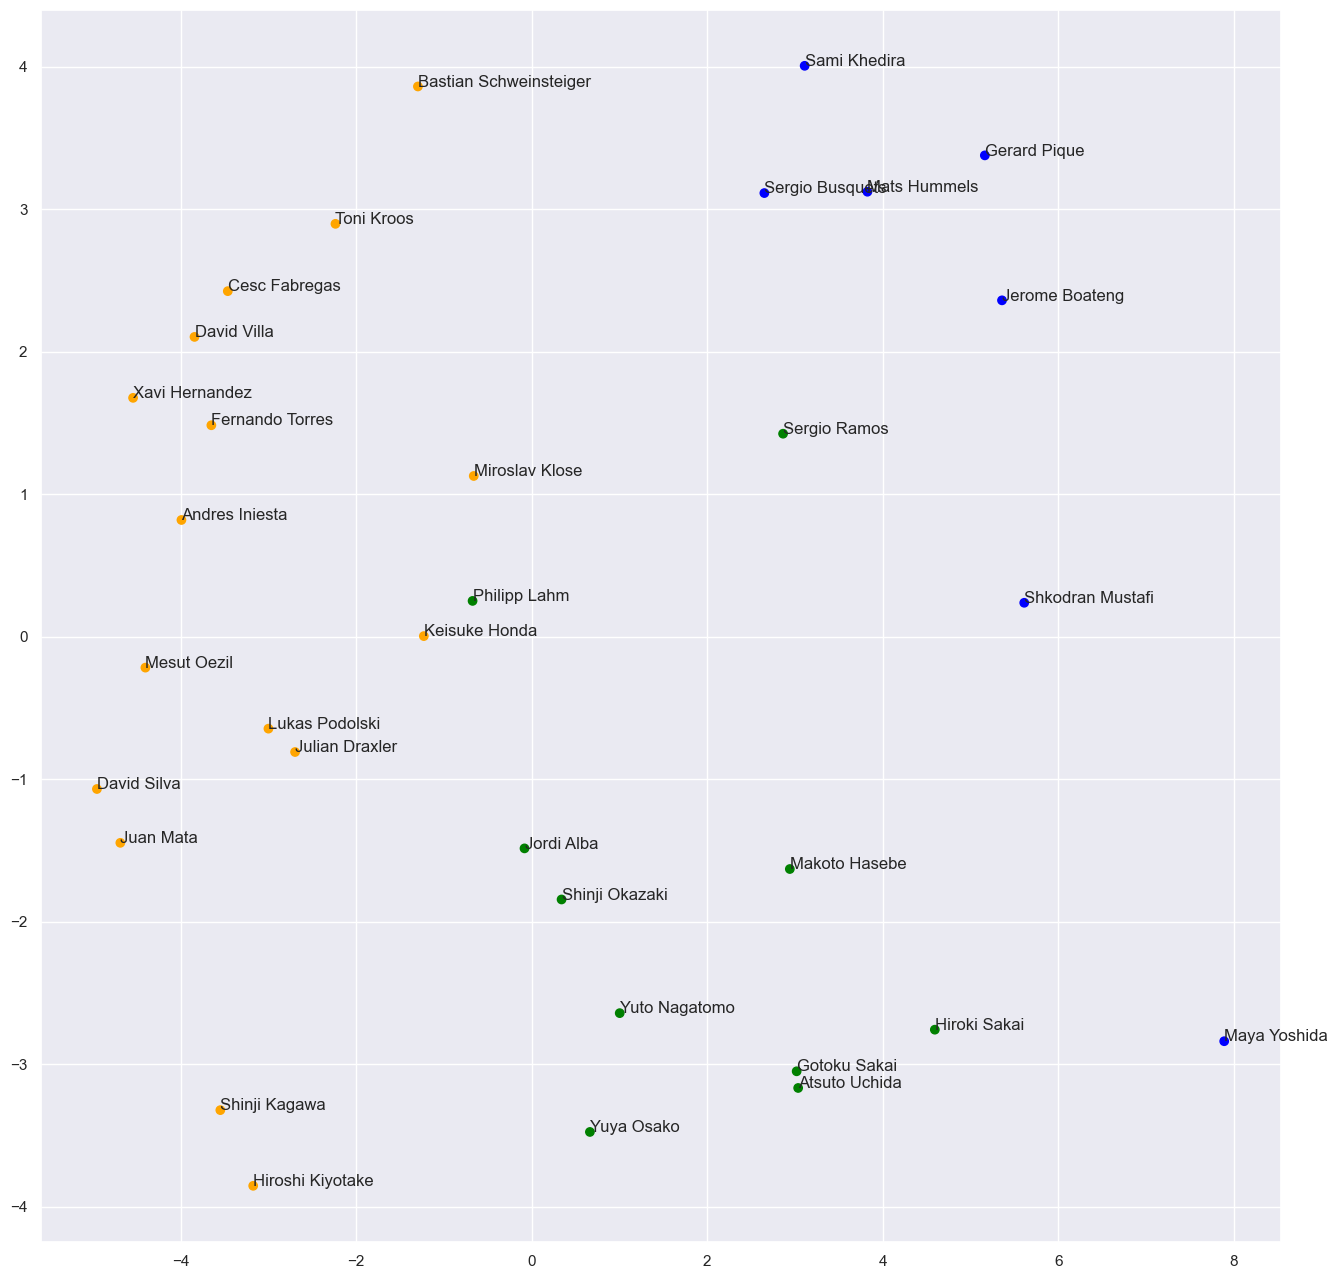

In [41]:
from sklearn.decomposition import TruncatedSVD

model_svd = TruncatedSVD(n_components=2)
vecs_list = model_svd.fit_transform(countries_player_scale)

X = vecs_list[:,0]
Y = vecs_list[:,1]

plt.figure(figsize=(16,16))

color_codes = {0:'blue',1:'orange',2:'green'}
colors = [color_codes[x] for x in group_num]
plt.scatter(X,Y,color=colors)

for i,(x_name,y_name) in enumerate(zip(X,Y)):
    plt.annotate(countries_player_scale.index[i],(x_name,y_name))
plt.show()

Clustering the players by each color, it seems that the players are classified by the above characteristics.

Based on the characteristics of each player, it seems that the X-axis is related to physical characteristics such as height, and the Y-axis is related to overall evaluation. If we look at Japanese players, though, we can see that they are clustered in the lower tier,
However, the players who played in the World Cup in Brazil were the first to play in the World Cup, and I think the cluster may be different if we look at the current evaluation axis, which is changing the view of Japanese players in Europe.

Next, let's also run the clustering of the hierarchy

Hierarchical clustering is effective when visualizing the actual distance between each player.
Non-hierarchical clustering is effective for grouping a large amount of data.

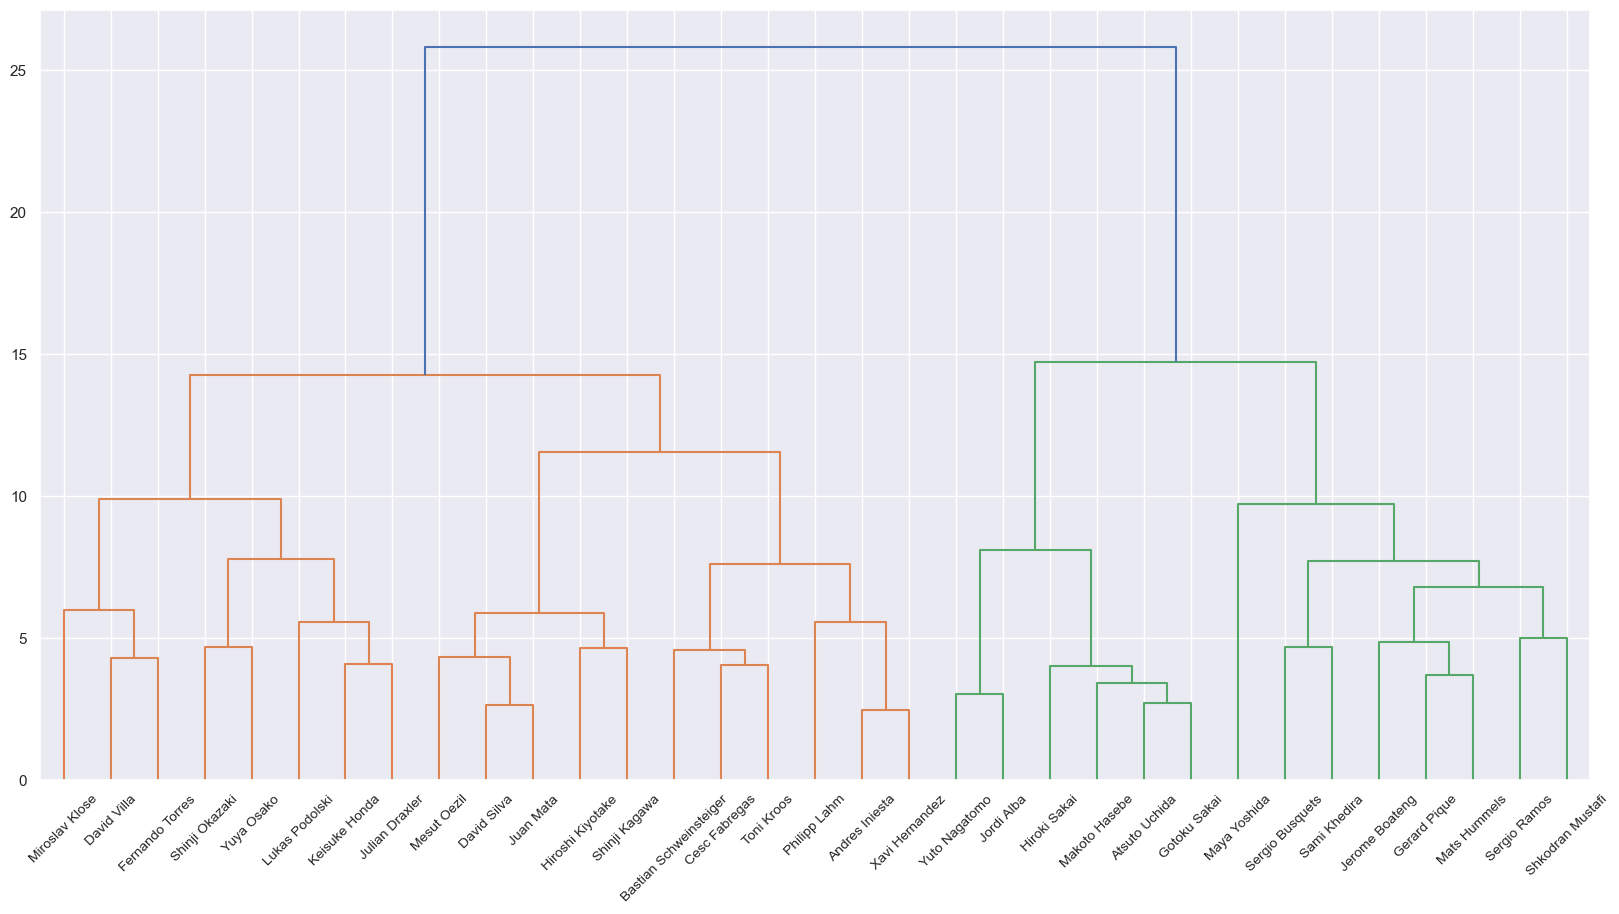

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

linkage_result = linkage(countries_player_scale, method='ward', metric='euclidean')

sns.set()
plt.figure(figsize=(20, 10))
dendrogram(linkage_result, labels=countries_player_scale.index, leaf_font_size=10)
plt.show()


The hierarchical clustering that was performed shows at a glance which players are actually similar types of players and which are not.

Japanese players were grouped similarly when non-hierarchical clustering was performed, but this time they appear to be separated by playing style.
This data does not include the position variables of the players, but it seems possible to assign variables to each position if we perform this hierarchical grouping.

Euclidean method: Calculate the square of the difference of features by √.

Check the average value of the players in the three categories in the hierarchy as well.

In [45]:
cluster_labels = cut_tree(linkage_result, n_clusters=3).reshape(-1, )
cluster_labels


array([0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1])

In [46]:
countries_player_scale['Cluster_Labels'] = cluster_labels
countries_player_scale.head()

overall_rating  potential  crossing  finishing  \
player_name                                                        
Atsuto Uchida          -1.318013  -1.573145  0.328148  -1.639974   
Gotoku Sakai           -1.670195  -1.233839  0.398012  -1.413297   
Hiroki Sakai           -2.022376  -1.912451 -0.300626  -1.809982   
Hiroshi Kiyotake       -1.141922  -1.064186  0.817195  -0.053235   
Keisuke Honda          -0.437559  -0.385575  0.328148   0.456789   

                  heading_accuracy  short_passing   volleys  dribbling  \
player_name                                                              
Atsuto Uchida            -0.475125      -0.548366 -2.279341  -0.129295   
Gotoku Sakai             -0.622346      -0.674033 -2.012373  -0.129295   
Hiroki Sakai              0.113762      -1.176701 -1.812147  -1.195983   
Hiroshi Kiyotake         -2.389007      -0.171364  0.390340   0.161619   
Keisuke Honda             0.040151      -0.171364  0.323598   0.452534   

                     curve  free_kick_accuracy  long_passing  ball_control  \
player_name                                                                  
Atsuto Uchida    -0.374834           -1.811637      0.124091     -0.556758   
Gotoku Sakai     -0.040523           -0.101713     -0.511340     -0.950465   
Hiroki Sakai     -0.040523           -0.608357     -0.864358     -1.737880   
Hiroshi Kiyotake  1.045989            1.354889      0.547712     -0.294286   
Keisuke Honda     1.463878            1.418220      0.265298      0.755600   

                  acceleration  sprint_speed   agility  reactions   balance  \
player_name                                                                   
Atsuto Uchida         0.135795      0.493517 -0.022432  -1.317395  0.082499   
Gotoku Sakai          0.135795      0.493517  0.070101  -1.494840  0.482859   
Hiroki Sakai          0.042436      0.298475 -0.485098  -1.849730 -0.638150   
Hiroshi Kiyotake      0.042436     -0.481696  0.902900  -0.430170  0.803147   
Keisuke Honda         0.229154      0.395996  0.347701  -1.317395 -0.638150   

                  shot_power   jumping   stamina  strength  long_shots  \
player_name                                                              
Atsuto Uchida      -0.433620 -0.025959  0.325343 -1.386712   -1.329648   
Gotoku Sakai       -1.101395 -0.311504  0.066636 -0.378408   -1.838173   
Hiroki Sakai       -0.338224 -1.263324 -0.192070  0.086963   -0.675831   
Hiroshi Kiyotake    0.234155 -0.406686 -1.744307 -1.696960    0.413864   
Keisuke Honda       1.283516  0.640315  0.325343  0.009401    1.067681   

                  aggression  interceptions  positioning    vision  penalties  \
player_name                                                                     
Atsuto Uchida      -0.006131       0.384715    -0.043955 -1.021670  -1.927276   
Gotoku Sakai        0.196202       0.384715    -0.624156 -1.442058  -1.376285   
Hiroki Sakai        0.533425      -0.167268    -0.769207 -1.442058  -2.320841   
Hiroshi Kiyotake   -2.501577      -1.672675    -0.261530  0.239494   0.040549   
Keisuke Honda      -0.141020      -0.719250     0.391197 -0.096817   0.512827   

                   marking  standing_tackle  sliding_tackle    height  \
player_name                                                             
Atsuto Uchida     0.793031         0.521348        0.730220 -0.664863   
Gotoku Sakai      0.514203         0.521348        0.613620 -0.664863   
Hiroki Sakai      0.713366         0.440953        0.691353  0.750651   
Hiroshi Kiyotake -1.318097        -1.488520       -1.251974 -1.018741   
Keisuke Honda     0.155709         0.159571        0.186088  0.396773   

                    weight  Cluster_Labels  
player_name                                 
Atsuto Uchida    -0.722302               0  
Gotoku Sakai     -0.165098               0  
Hiroki Sakai     -0.041274               0  
Hiroshi Kiyotake -1.217595               1  
Keisuke Honda     0.144460               1

In [47]:
countries_player_scale = countries_player_scale[['overall_rating','finishing','short_passing','free_kick_accuracy',
                           'height','weight','positioning','agility','dribbling','heading_accuracy','Cluster_Labels']].groupby('Cluster_Labels').mean()
countries_player_scale = countries_player_scale.T
countries_player_scale

Cluster_Labels             0         1         2
overall_rating     -1.200619  0.331680  0.112725
finishing          -1.101616  0.641709 -0.697847
short_passing      -0.653088  0.370989 -0.391282
free_kick_accuracy -0.597802  0.574924 -0.917093
height             -0.546903 -0.310984  1.148765
weight             -0.546886 -0.305213  1.135046
positioning        -0.370318  0.654577 -1.276883
agility             0.270590  0.430493 -1.225364
dribbling          -0.307077  0.682204 -1.389927
heading_accuracy   -0.438319 -0.300783  1.043099

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

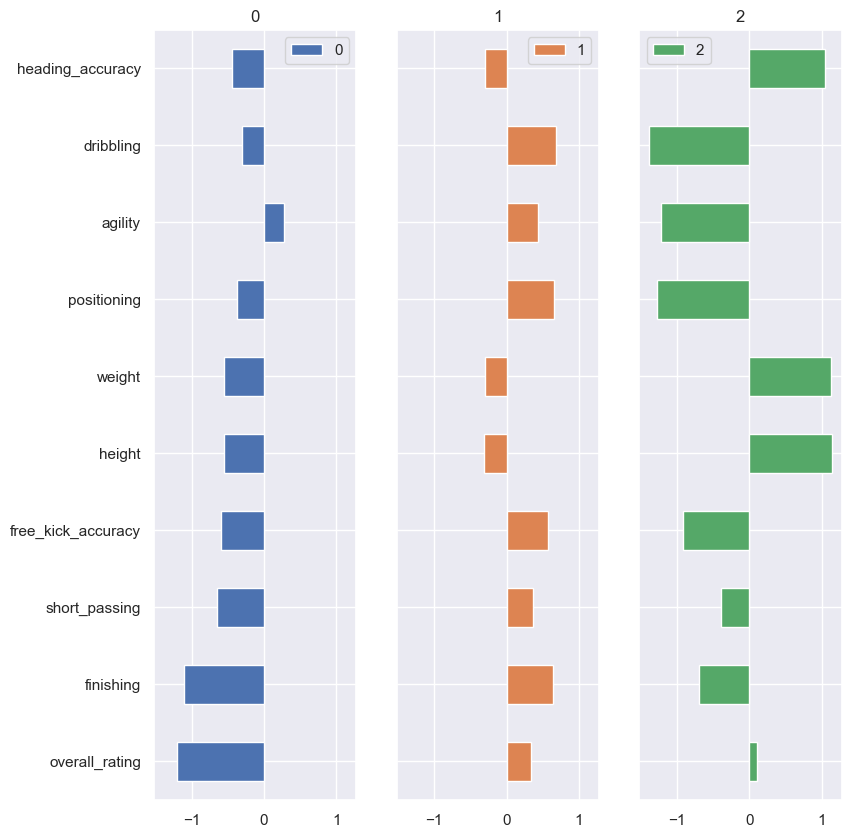

In [48]:
countries_player_scale[0:].plot(figsize=(12,10),kind='barh',subplots=True,layout=(1,4),sharey=True)

When classified by average, the classification was the same as in the non-hierarchy

Looking at the stages of the hierarchy, it can be expected that the yellow areas would be classified into two categories, one closer to FW and the other closer to MF, when classified into four categories

# League Projections

In [50]:
countries

id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

In [51]:
matches.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   
2        492475              9984              8635               0   
3        492476              9991              9998               5   
4        492477              7947              9985               1   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   
2               3             NaN             NaN             NaN   
3               0             NaN             NaN             NaN   
4               3             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   
3             NaN             NaN              NaN              NaN   
4             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   
2             NaN              NaN              NaN             NaN   
3             NaN              NaN              NaN             NaN   
4             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2            

In [52]:
leagues

id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super League

In [53]:
teams.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [54]:
print(countries.shape)
print(matches.shape)
print(leagues.shape)
print(teams.shape)

(11, 2)
(25979, 115)
(11, 3)
(299, 5)


In [55]:
#select relevant countries and merge with leagues

selected_countries = ['England','France','Germany','Italy','Spain','Belgium']

countries = countries[countries.name.isin(selected_countries)]

leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [58]:
countries

id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy
9  21518    Spain

In [59]:
leagues


id     name  country_id                  name_y
0      1  Belgium           1  Belgium Jupiler League
1   1729  England        1729  England Premier League
2   4769   France        4769          France Ligue 1
3   7809  Germany        7809   Germany 1. Bundesliga
4  10257    Italy       10257           Italy Serie A
5  21518    Spain       21518         Spain LIGA BBVA

In [60]:
matches.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   
2        492475              9984              8635               0   
3        492476              9991              9998               5   
4        492477              7947              9985               1   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   
2               3             NaN             NaN             NaN   
3               0             NaN             NaN             NaN   
4               3             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   
3             NaN             NaN              NaN              NaN   
4             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   
2             NaN              NaN              NaN             NaN   
3             NaN              NaN              NaN             NaN   
4             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2            

In [61]:
#select relevant fields

matches = matches[matches.league_id.isin(leagues.id)]

matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

matches.dropna(inplace=True)

matches.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  B365H  B365D  B365A  
0        492473              9987              9993   1.73   3.40   5.00  
1        492474             10000              9994   1.95   3.20   3.60  
2        492475              9984              8635   2.38   3.30   2.75  
3        492476              9991              9998   1.44   3.75   7.50  
4        492477              7947              9985   5.00   3.50   1.65

B365H：Home Game Odds

B365D：Draw Game Odds

B365A：Odds for away games

In [62]:
from scipy.stats import entropy



def match_entropy(row):

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #change odds to probability

    probs = [1/o for o in odds]

    #normalize to sum to 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)



#compute match entropy

matches['entropy'] = matches.apply(match_entropy,axis=1)

In [63]:
matches.head()


id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  B365H  B365D  B365A  \
0        492473              9987              9993   1.73   3.40   5.00   
1        492474             10000              9994   1.95   3.20   3.60   
2        492475              9984              8635   2.38   3.30   2.75   
3        492476              9991              9998   1.44   3.75   7.50   
4        492477              7947              9985   5.00   3.50   1.65   

    entropy  
0  1.001117  
1  1.060663  
2  1.089842  
3  0.889142  
4  0.988467

In [64]:
#compute mean entropy for every league in every season

entropy_means = matches.groupby(['season','league_id']).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]

entropy_means.head(10)

Belgium   England    France   Germany     Italy     Spain
season                                                               
2008/2009  0.994534  0.984556  1.026638  1.004276  1.002201  1.010859
2009/2010  1.002933  0.956496  1.013821  0.997925  1.006755  0.977810
2010/2011  1.001498  0.983258  1.026236  1.016264  1.006029  0.975032
2011/2012  0.993622  0.969593  1.024915  1.001298  1.003077  0.955339
2012/2013  1.000187  0.981472  1.016116  0.993993  1.003565  0.970580
2013/2014       NaN  0.960473  1.004439  0.977500  0.992622  0.944218
2014/2015  0.999532  0.980301  1.012495  0.985835  0.999100  0.933637
2015/2016  1.000230  0.997819  1.013928  0.974657  0.985284  0.946813

Text(7.3, 0.952, 'more predictable')

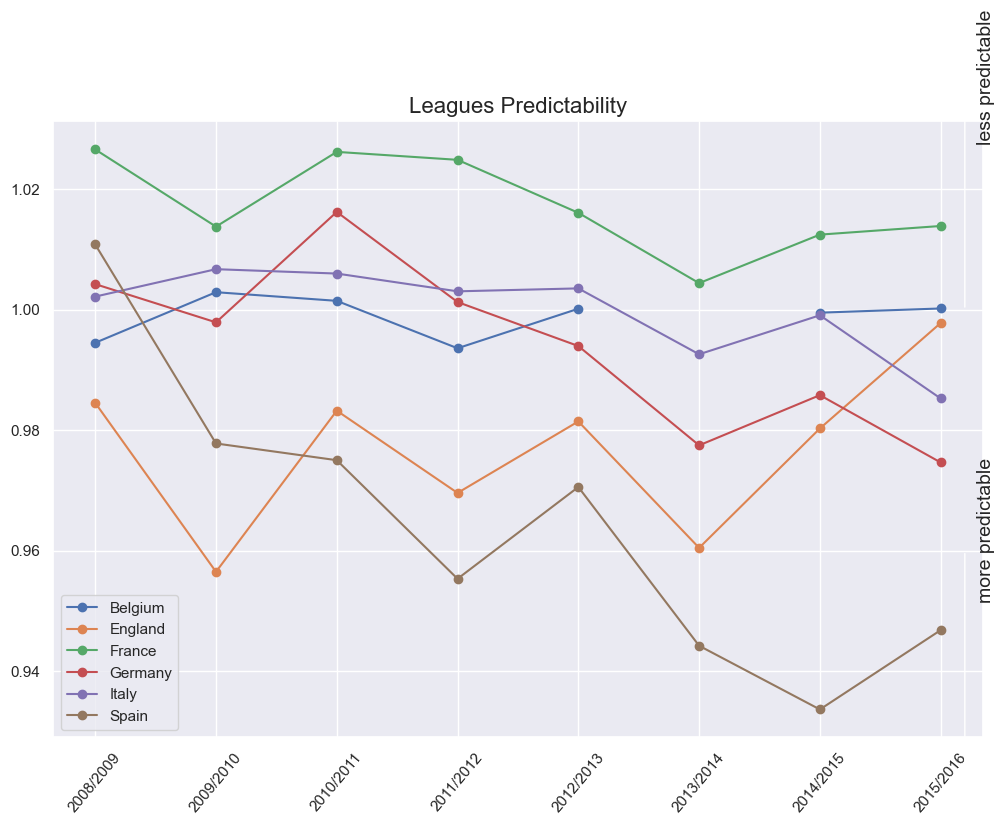

In [65]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

#Football Deep Dive

In [72]:
import numpy as np # linear algebra
path = "/users/ganeshmakkina/desktop/"  #Insert path here
db = path + 'database.sqlite'
conn = sqlite3.connect(db)


In [73]:
conn = sqlite3.connect(db)
master_table = pd.read_sql("""SELECT * 
                    FROM sqlite_master
                    WHERE type='table';""", conn)
print(master_table.tbl_name.to_list())

['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes']


In [75]:
## count of Columns of all table

sqlite_sequence_table = pd.read_sql("""SELECT *
                        FROM sqlite_sequence;""", conn)
player_attributes_table = pd.read_sql("""SELECT *
                        FROM player_attributes;""", conn)
player_table = pd.read_sql("""SELECT *
                        FROM player;""", conn)
match_table = pd.read_sql("""SELECT *
                        FROM match;""", conn)
league_table = pd.read_sql("""SELECT *
                        FROM league;""", conn)
country_table = pd.read_sql("""SELECT *
                        FROM country;""", conn)
team_table = pd.read_sql("""SELECT *
                        FROM team;""", conn)
team_attributes = pd.read_sql("""SELECT *
                        FROM team_attributes;""", conn)

print('No of columns for sqlite_sequence_table_table are :',len(sqlite_sequence_table.columns))
print('\n')
print('No of columns for player_attributes_table are :',len(player_attributes_table.columns))
print('\n')
print('No of columns for player_table are :',len(player_table.columns))
print('\n')
print('No of columns for match_table are :',len(match_table.columns))
print('\n')
print('No of columns for league_table are :',len(match_table.columns))
print('\n')
print('No of columns for country_table are :',len(country_table.columns))
print('\n')
print('No of columns for team_table are :',len(team_table.columns))
print('\n')
print('No of columns for team_attributes are :',len(team_attributes.columns))

No of columns for sqlite_sequence_table_table are : 2


No of columns for player_attributes_table are : 42


No of columns for player_table are : 7


No of columns for match_table are : 115


No of columns for league_table are : 115


No of columns for country_table are : 2


No of columns for team_table are : 5


No of columns for team_attributes are : 25


**Database Schema**

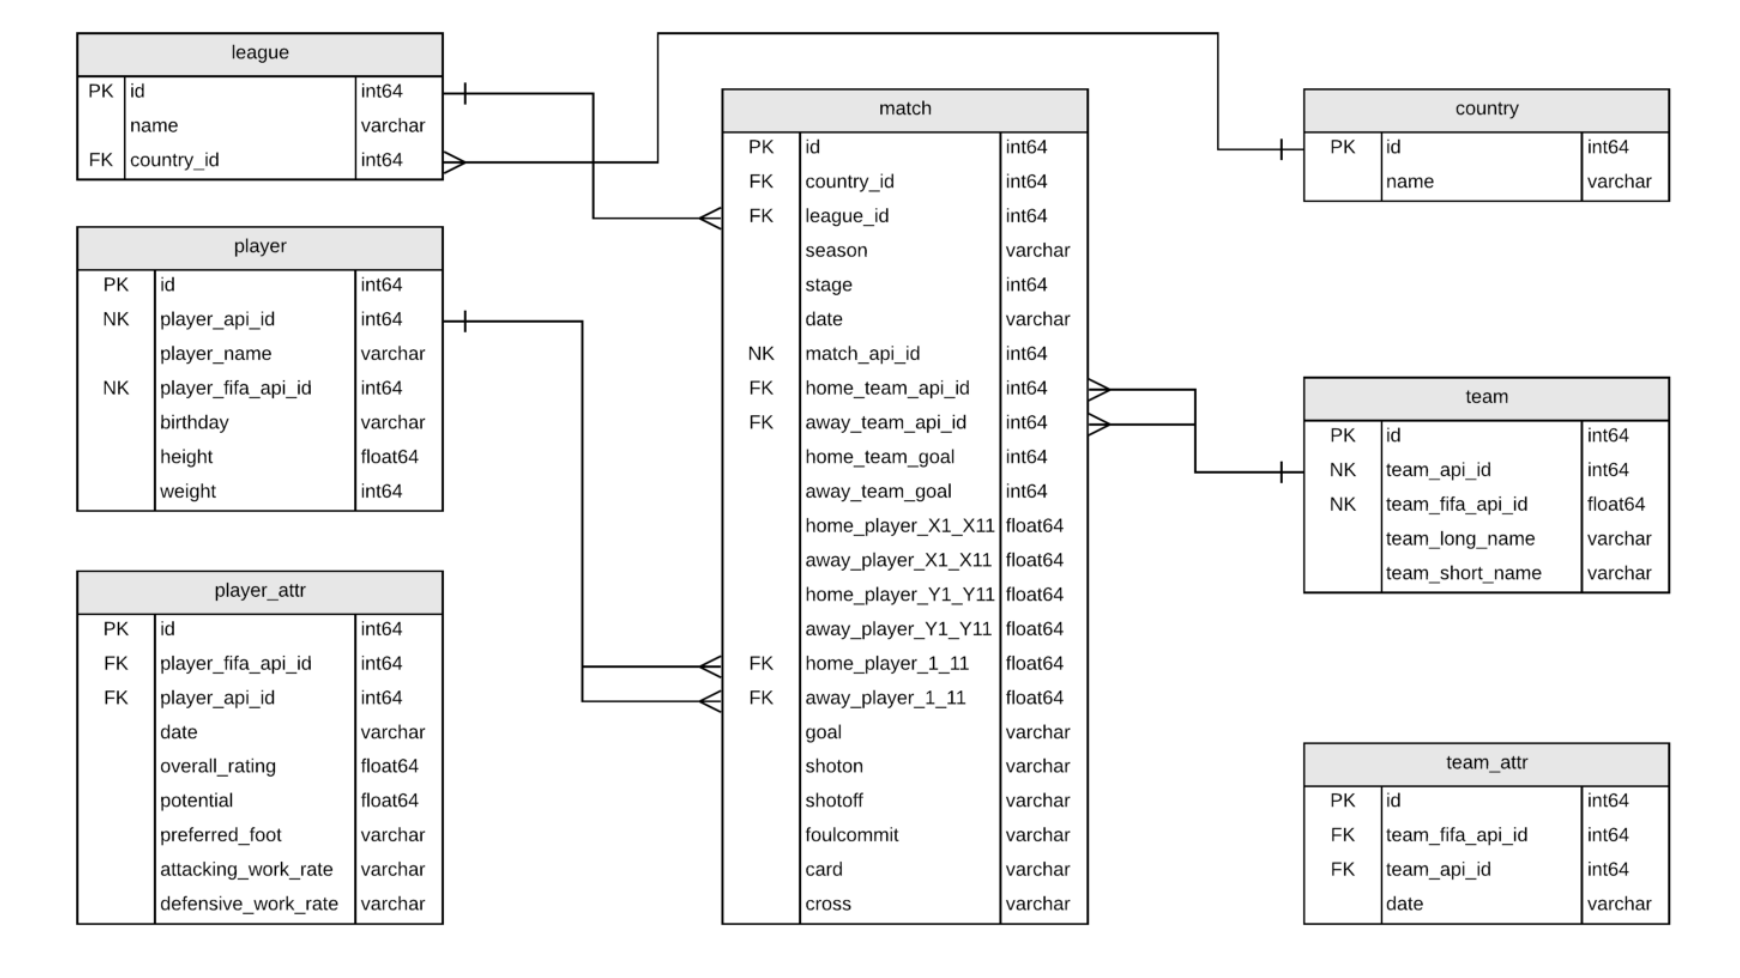

In [76]:

sql = pd.read_sql(""" select id,name from league
group by name
""", conn)
sql.head()

id                    name
0      1  Belgium Jupiler League
1   1729  England Premier League
2   4769          France Ligue 1
3   7809   Germany 1. Bundesliga
4  10257           Italy Serie A

In [77]:
##Query 2:- League vs Country Name

sql = pd.read_sql(""" 
select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name""", conn)
sql.head(100)

id                leagueName  countryName
0       1    Belgium Jupiler League      Belgium
1    1729    England Premier League      England
2    4769            France Ligue 1       France
3    7809     Germany 1. Bundesliga      Germany
4   10257             Italy Serie A        Italy
5   13274    Netherlands Eredivisie  Netherlands
6   15722        Poland Ekstraklasa       Poland
7   17642  Portugal Liga ZON Sagres     Portugal
8   19694   Scotland Premier League     Scotland
9   21518           Spain LIGA BBVA        Spain
10  24558  Switzerland Super League  Switzerland

In [78]:
##Query 3:- Teams associated with the leagues (Country vs League vs Teams)

sql = pd.read_sql(""" 

select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename

""", conn)
sql.head()

countryName              LeagueName TeamInTheLeague
0     Belgium  Belgium Jupiler League    Beerschot AC
1     Belgium  Belgium Jupiler League  Club Brugge KV
2     Belgium  Belgium Jupiler League   FCV Dender EH
3     Belgium  Belgium Jupiler League        KAA Gent
4     Belgium  Belgium Jupiler League       KAS Eupen

In [79]:
##Query 5:-  Away Team Info
sql = pd.read_sql(""" 

select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id
""", conn)
sql.head()

match_api_id  away_team_api_id team_long_name team_short_name
0        483129              9830      FC Nantes             NAN
1        483130              7819        SM Caen             CAE
2        483131              9831       OGC Nice             NIC
3        483132              8689     FC Lorient             LOR
4        483133              9941    Toulouse FC             TOU

In [80]:
##Query 7:-  Match By Match RAW
sql = pd.read_sql(""" 
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id

""", conn)
sql.head()

match_api_id countryname      leaguename    Home_Team_Long_Name  \
0        483129      France  France Ligue 1             AJ Auxerre   
1        483130      France  France Ligue 1  Girondins de Bordeaux   
2        483131      France  France Ligue 1            Le Havre AC   
3        483132      France  France Ligue 1             Le Mans FC   
4        483133      France  France Ligue 1     Olympique Lyonnais   

  Home_Team_Short_Name Away_Team_Long_Name Away_Team_Short_Name     season  \
0                  AUX           FC Nantes                  NAN  2008/2009   
1                  BOR             SM Caen                  CAE  2008/2009   
2                  LEH            OGC Nice                  NIC  2008/2009   
3                  LEM          FC Lorient                  LOR  2008/2009   
4                  LYO         Toulouse FC                  TOU  2008/2009   

         Date  stage  home_team_goal  away_team_goal Match_Winner  
0  09-08-2008      1               2               1          AUX  
1  09-08-2008      1               2               1          BOR  
2  09-08-2008      1               1               0          LEH  
3  09-08-2008      1               0               1          LOR  
4  10-08-2008      1               3               0          LYO

In [81]:
##Query 8:Goals scored by home team vs away team Season on Season
sql = pd.read_sql(""" 

select
at_table.season,
at_table.leaguename,
ht_table.HT_goals as Home_Team_Goals,
at_table.AT_goals as Away_Team_Goals
from (
select 
b.season,
b.leaguename,
sum(home_team_goal) as HT_goals
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) b

group by b.season,b.leaguename ) ht_table join 
(select 
b.season,
b.leaguename,
sum(away_team_goal) as AT_goals
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) b

group by b.season,b.leaguename) at_Table on ht_table.leaguename=at_table.leaguename and ht_table.season=at_table.season
""", conn)
sql.head()

season              leaguename  Home_Team_Goals  Away_Team_Goals
0  2008/2009  Belgium Jupiler League              499              356
1  2008/2009  England Premier League              532              410
2  2008/2009          France Ligue 1              489              369
3  2008/2009   Germany 1. Bundesliga              520              374
4  2008/2009           Italy Serie A              578              410

In [82]:
##Query 10:-  Matches won by Teams Season on Season
sql = pd.read_sql(""" 
select 
a.season,a.match_winner,count(a.match_winner) as Number_of_Wins
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_long_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_long_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) a
group by a.season,a.match_winner

""", conn)
sql.head()

season   Match_Winner  Number_of_Wins
0  2008/2009     1. FC Köln              11
1  2008/2009  AC Bellinzona              11
2  2008/2009   ADO Den Haag               8
3  2008/2009     AJ Auxerre              16
4  2008/2009      AS Monaco              11

In [83]:
##Query 11:-  Most Successful Teams compared for all seasons

sql = pd.read_sql(""" 
select * from (
select 
a.team,
sum(a.total_games),
sum(a.wins),
100*round(round(a.wins,2)/round(a.total_games,2),4) as Win_Percentage from
(select 
total_matches.season,
total_matches.team,
Total_games_played_for_the_season as total_games,
win_matches.number_of_wins as wins
from (
select 
ht.season as Season,
ht.team as Team ,
ht.home_games_played,
at.away_games_played,
ht.home_games_played + at.away_games_played as Total_games_played_for_the_season
from (
select b.season as Season,b.home_team_long_name as Team ,count(b.match_api_id) as home_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name ) ht
join (select b.season as Season,b.away_team_long_name as team,count(b.match_api_id) as away_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name) at on ht.season=at.season and ht.team=at.team ) total_matches join 
(select 
a.season,a.match_winner,count(a.match_winner) as Number_of_Wins
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_long_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_long_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) a
group by a.season,a.match_winner) win_matches on total_matches.team=win_matches.match_winner) a
group by a.team)b
group by b.team
order by b.win_percentage desc
""", conn)
sql.head()

team  sum(a.total_games)  sum(a.wins)  Win_Percentage
0  Manchester United                2432         1536           73.68
1                 AZ                2176         1120           73.53
2       FC Barcelona                2432         1872           71.05
3  Standard de Liège                1484          742           70.59
4     RSC Anderlecht                1484          952           70.59

In [85]:
#https://www.kaggle.com/code/efezinoerome/analyzing-soccer-data
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
con = sqlite3.connect('/users/ganeshmakkina/desktop/database.sqlite')
cursor = con.cursor()
table_names = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [88]:
player_table = pd.read_sql_query("SELECT * FROM Player", con)
player_att_table = pd.read_sql_query("SELECT * FROM Player_Attributes", con)
match_table = pd.read_sql_query("SELECT * FROM Match", con)
league_table = pd.read_sql_query("SELECT * FROM League", con)
country_table = pd.read_sql_query("SELECT * FROM Country", con)
team_table = pd.read_sql_query("SELECT * FROM Team", con)
team_att_table = pd.read_sql_query("SELECT * FROM Team_Attributes", con)

**Analyzing Country Table**

In [89]:
print("Dimension of Country Table is: {}".format(country_table.shape))
print(100*"*")
print(country_table.info())
print(100*"*")
print(country_table.select_dtypes(exclude=['float64','int64']).describe())
print(100*"*")
print(country_table.describe())
print(100*"*")
print(country_table.isnull().sum(axis=0))

Dimension of Country Table is: (11, 2)
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes
None
****************************************************************************************************
           name
count        11
unique       11
top     Belgium
freq          1
****************************************************************************************************
                 id
count     11.000000
mean   12452.090909
std     8215.308472
min        1.000000
25%     6289.000000
50%    13274.000000
75%    18668.000000
max    24558.000000
********************************************************************************************

In [90]:
country_table


id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

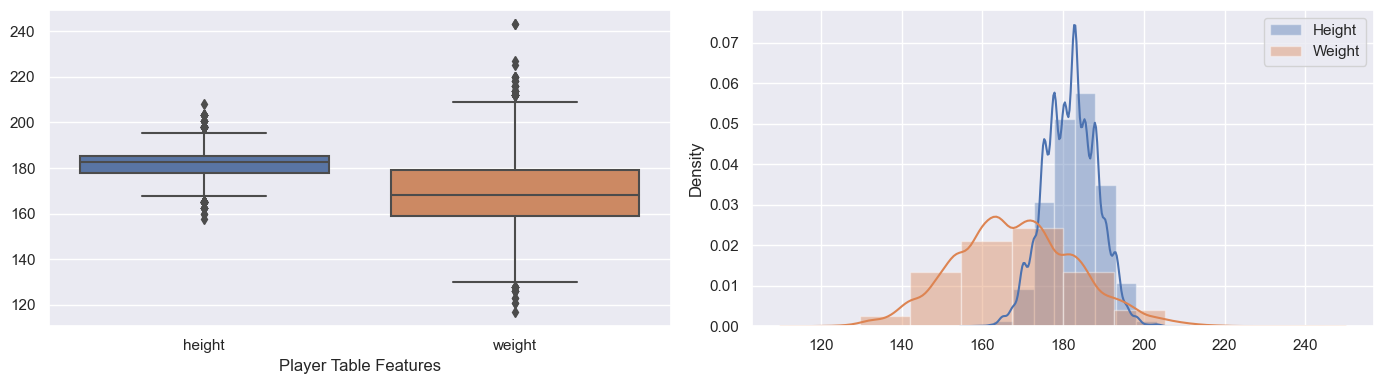

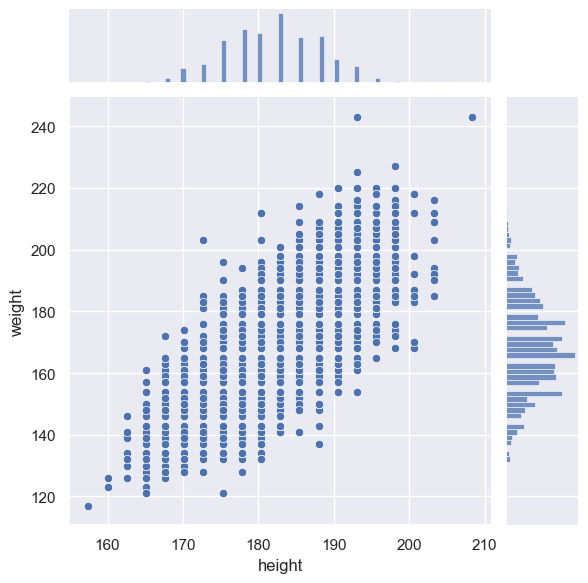

In [91]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 2)
fig1.set_size_inches(14,4)
sns.boxplot(data = player_table.loc[:,["height",'weight']], ax = ax1[0])
ax1[0].set_xlabel('Player Table Features')
ax1[0].set_ylabel('')
sns.distplot(a = player_table.loc[:,["height"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Height')
sns.distplot(a = player_table.loc[:,["weight"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Weight')
ax1[1].legend()
sns.jointplot(x='height',y = 'weight',data = player_table,kind = 'scatter')
fig1.tight_layout()

In [92]:
np.unique(player_att_table.dtypes.values)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [93]:
player_att_table.select_dtypes(include =['float64','int64']).head().\
loc[:,player_att_table.select_dtypes(include =['float64','int64']).columns[3:]].head()

overall_rating  potential  crossing  finishing  heading_accuracy  \
0            67.0       71.0      49.0       44.0              71.0   
1            67.0       71.0      49.0       44.0              71.0   
2            62.0       66.0      49.0       44.0              71.0   
3            61.0       65.0      48.0       43.0              70.0   
4            61.0       65.0      48.0       43.0              70.0   

   short_passing  volleys  dribbling  curve  free_kick_accuracy  long_passing  \
0           61.0     44.0       51.0   45.0                39.0          64.0   
1           61.0     44.0       51.0   45.0                39.0          64.0   
2           61.0     44.0       51.0   45.0                39.0          64.0   
3           60.0     43.0       50.0   44.0                38.0          63.0   
4           60.0     43.0       50.0   44.0                38.0          63.0   

   ball_control  acceleration  sprint_speed  agility  reactions  balance  \
0          49.0          60.0          64.0     59.0       47.0     65.0   
1          49.0          60.0          64.0     59.0       47.0     65.0   
2          49.0          60.0          64.0     59.0       47.0     65.0   
3          48.0          60.0          64.0     59.0       46.0     65.0   
4          48.0          60.0          64.0     59.0       46.0     65.0   

   shot_power  jumping  stamina  strength  long_shots  aggression  \
0        55.0     58.0     54.0      76.0        35.0        71.0   
1        55.0     58.0     54.0      76.0        35.0        71.0   
2        55.0     58.0     54.0      76.0        35.0        63.0   
3        54.0     58.0     54.0      76.0        34.0        62.0   
4        54.0     58.0     54.0      76.0        34.0        62.0   

   interceptions  positioning  vision  penalties  marking  standing_tackle  \
0           70.0         45.0    54.0       48.0     65.0             69.0   
1           70.0         45.0    54.0       48.0     65.0             69.0   
2           41.0         45.0    54.0       48.0     65.0             66.0   
3           40.0         44.0    53.0       47.0     62.0             63.0   
4           40.0         44.0    53.0       47.0     62.0             63.0   

   sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0            69.0        6.0         11.0        10.0             8.0   
1            69.0        6.0         11.0        10.0             8.0   
2            69.0        6.0         11.0        10.0             8.0   
3            66.0        5.0         10.0         9.0             7.0   
4            66.0        5.0         10.0         9.0             7.0   

   gk_reflexes  
0          8.0  
1          8.0  
2          8.0  
3          7.0  
4          7.0

In [94]:
corr2 = player_att_table.select_dtypes(include =['float64','int64']).\
loc[:,player_att_table.select_dtypes(include =['float64','int64']).columns[3:]].corr()

<Axes: >

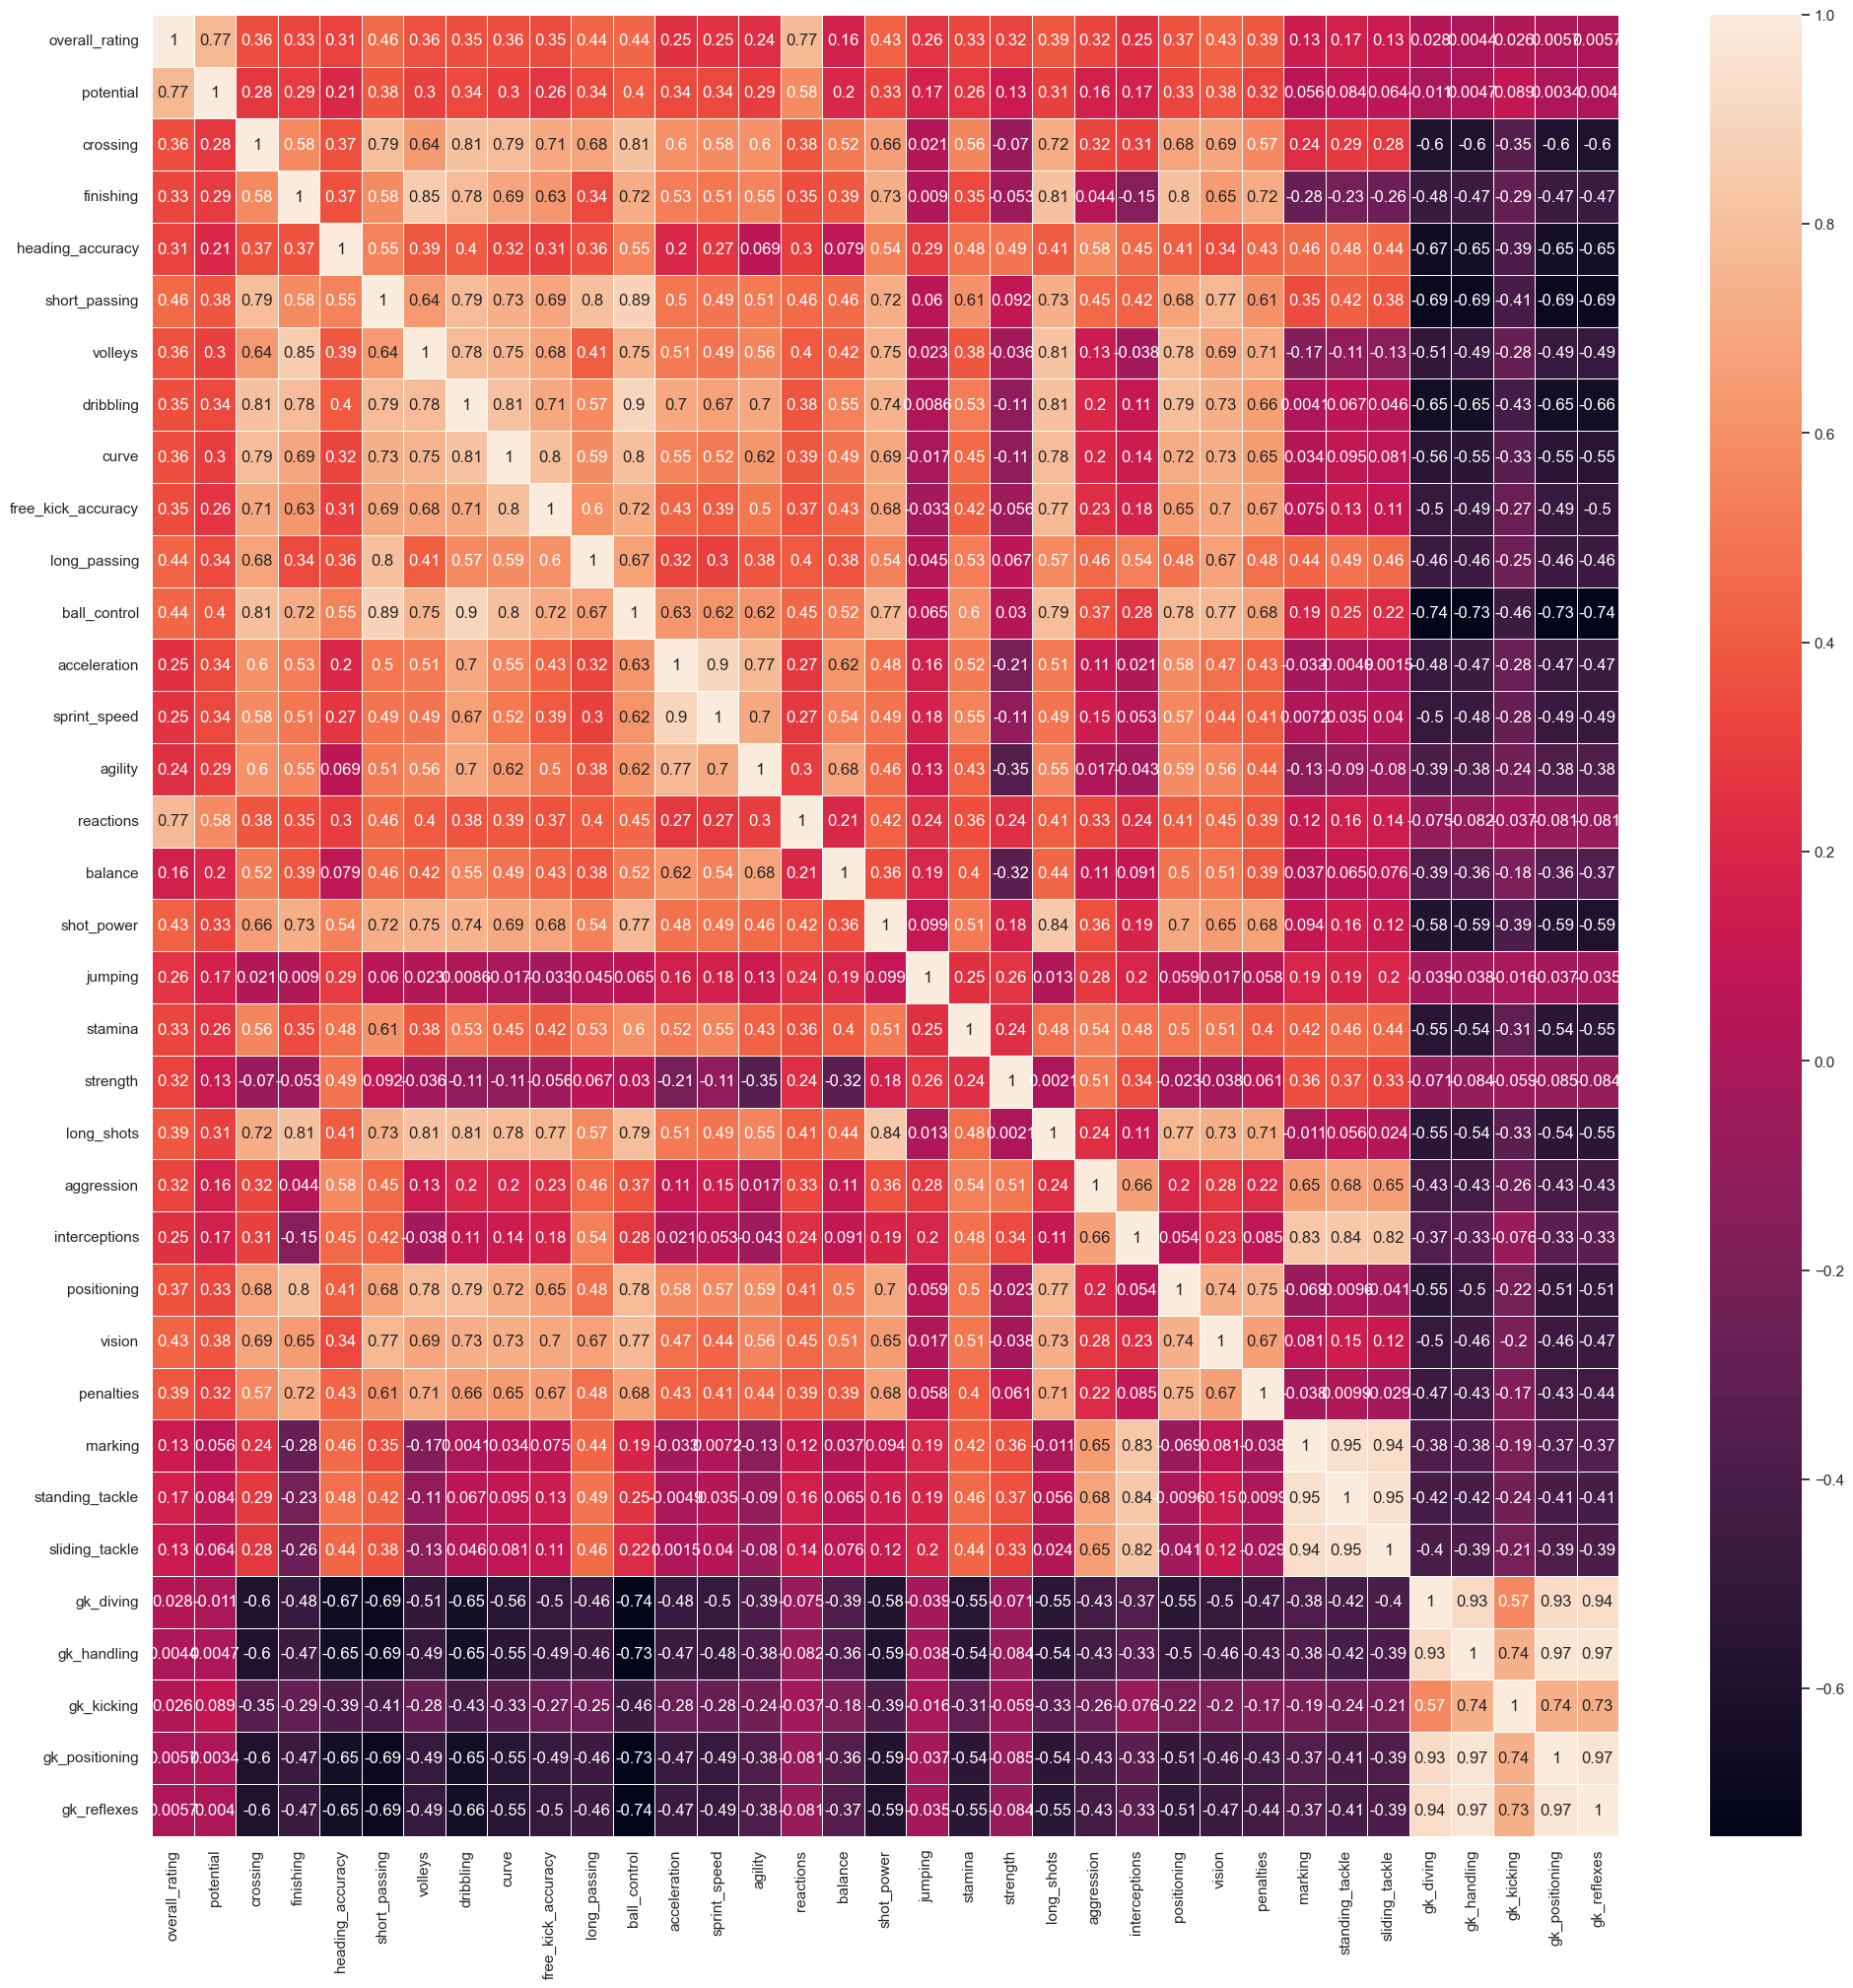

In [95]:
fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

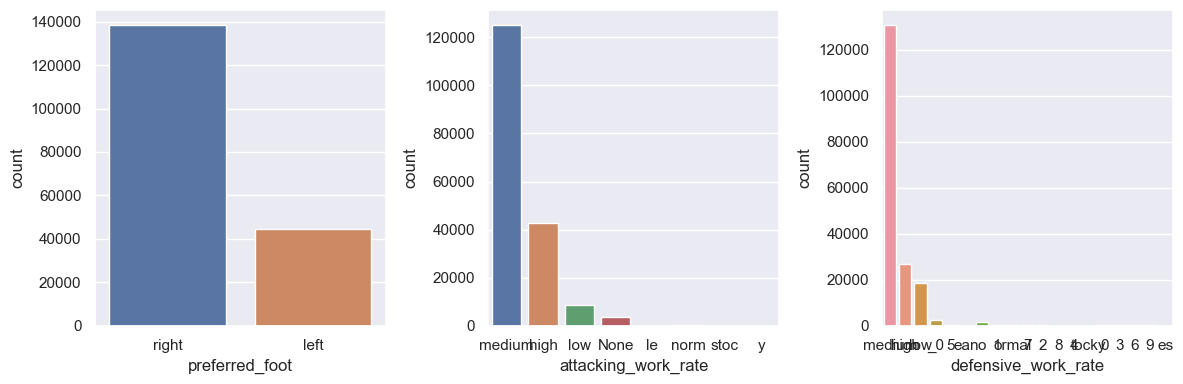

In [96]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 3)
fig3.set_size_inches(12,4)
sns.countplot(x = player_att_table['preferred_foot'],ax = ax3[0])
sns.countplot(x = player_att_table['attacking_work_rate'],ax = ax3[1])
sns.countplot(x = player_att_table['defensive_work_rate'],ax = ax3[2])
fig3.tight_layout()


In [97]:
player_att_table.loc[~(player_att_table['attacking_work_rate'].\
                                                  isin(['medium','high','low'])\
                       | player_att_table['defensive_work_rate'].isin(['medium','high','low'])),:].head()

id  player_fifa_api_id  player_api_id                 date  \
373  374              156626          46447  2010-08-30 00:00:00   
374  375              156626          46447  2010-02-22 00:00:00   
375  376              156626          46447  2008-08-30 00:00:00   
376  377              156626          46447  2007-08-30 00:00:00   
377  378              156626          46447  2007-02-22 00:00:00   

     overall_rating  potential preferred_foot attacking_work_rate  \
373            64.0       71.0          right                None   
374            64.0       71.0          right                None   
375            66.0       71.0          right                None   
376            68.0       75.0          right                None   
377            66.0       65.0          right                None   

    defensive_work_rate  crossing  finishing  heading_accuracy  short_passing  \
373                  _0      41.0       33.0              74.0           57.0   
374                  _0      41.0       33.0              74.0           57.0   
375                  _0      41.0       33.0              74.0           57.0   
376                  _0      41.0       33.0              74.0           57.0   
377                  _0      41.0       33.0              70.0           51.0   

     volleys  dribbling  curve  free_kick_accuracy  long_passing  \
373     24.0       30.0   35.0                40.0          45.0   
374     24.0       30.0   35.0                40.0          45.0   
375     24.0       30.0   35.0                40.0          45.0   
376     24.0       30.0   35.0                40.0          45.0   
377     24.0       30.0   35.0                55.0          45.0   

     ball_control  acceleration  sprint_speed  agility  reactions  balance  \
373          44.0          60.0          61.0     59.0       58.0     73.0   
374          44.0          60.0          61.0     59.0       58.0     73.0   
375          44.0          60.0          61.0     59.0       58.0     73.0   
376          44.0          60.0          61.0     59.0       62.0     73.0   
377          44.0          60.0          61.0     59.0       62.0     73.0   

     shot_power  jumping  stamina  strength  long_shots  aggression  \
373        48.0     75.0     64.0      71.0        39.0        71.0   
374        48.0     75.0     64.0      71.0        39.0        71.0   
375        48.0     75.0     64.0      74.0        39.0        71.0   
376        48.0     75.0     72.0      74.0        39.0        76.0   
377        48.0     75.0     72.0      74.0        39.0        76.0   

     interceptions  positioning  vision  penalties  marking  standing_tackle  \
373           58.0         28.0    61.0       39.0     62.0             61.0   
374           62.0         66.0    61.0       58.0     62.0             61.0   
375           62.0         66.0    61.0       58.0     67.0             61.0   
376           66.0         69.0    61.0       58.0     69.0             64.0   
377           66.0         69.0    61.0       55.0     66.0             63.0   

     sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
373            57.0       15.0         14.0        13.0            10.0   
374            57.0        6.0         20.0        45.0            20.0   
375            57.0        6.0         20.0        45.0            20.0   
376            57.0        6.0         20.0        45.0            20.0   
377            57.0        6.0          9.0        45.0            13.0   

     gk_reflexes  
373         12.0  
374         20.0  
375         20.0  
376         20.0  
377         10.0

In [98]:
player_att_table_updated1 = player_att_table.loc[(player_att_table['attacking_work_rate'].\
                                                  isin(['medium','high','low'])\
                       & player_att_table['defensive_work_rate'].isin(['medium','high','low'])),:]
print(player_att_table_updated1.shape)
player_att_table_updated1.head()

(176161, 42)


id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0       44.0              71.0           61.0     44.0       51.0   45.0   
1       44.0              71.0           61.0     44.0       51.0   45.0   
2       44.0              71.0           61.0     44.0       51.0   45.0   
3       43.0              70.0           60.0     43.0       50.0   44.0   
4       43.0              70.0           60.0     43.0       50.0   44.0   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                39.0          64.0          49.0          60.0          64.0   
1                39.0          64.0          49.0          60.0          64.0   
2                39.0          64.0          49.0          60.0          64.0   
3                38.0          63.0          48.0          60.0          64.0   
4                38.0          63.0          48.0          60.0          64.0   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
1     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
2     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
3     59.0       46.0     65.0        54.0     58.0     54.0      76.0   
4     59.0       46.0     65.0        54.0     58.0     54.0      76.0   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0        35.0        71.0           70.0         45.0    54.0       48.0   
1        35.0        71.0           70.0         45.0    54.0       48.0   
2        35.0        63.0           41.0         45.0    54.0       48.0   
3        34.0        62.0           40.0         44.0    53.0       47.0   
4        34.0        62.0           40.0         44.0    53.0       47.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   
3     62.0             63.0            66.0        5.0         10.0   
4     62.0             63.0            66.0        5.0         10.0   

   gk_kicking  gk_positioning  gk_reflexes  
0        10.0             8.0          8.0  
1        10.0             8.0          8.0  
2        10.0             8.0          8.0  
3         9.0             7.0          7.0  
4         9.0             7.0          7.0

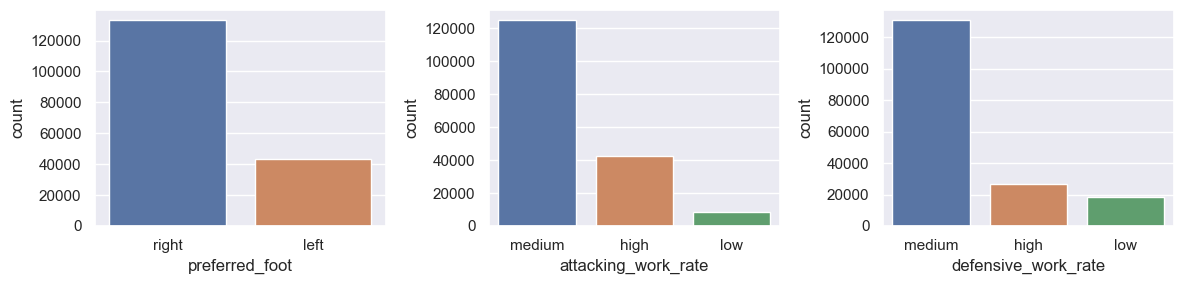

In [99]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3)
fig4.set_size_inches(12,3)
sns.countplot(x = player_att_table_updated1['preferred_foot'],ax = ax4[0])
sns.countplot(x = player_att_table_updated1['attacking_work_rate'],ax = ax4[1])
sns.countplot(x = player_att_table_updated1['defensive_work_rate'],ax = ax4[2])
fig4.tight_layout()

In [101]:
pat = player_att_table_updated1.loc[:,player_att_table_updated1.columns.tolist()[3:]]

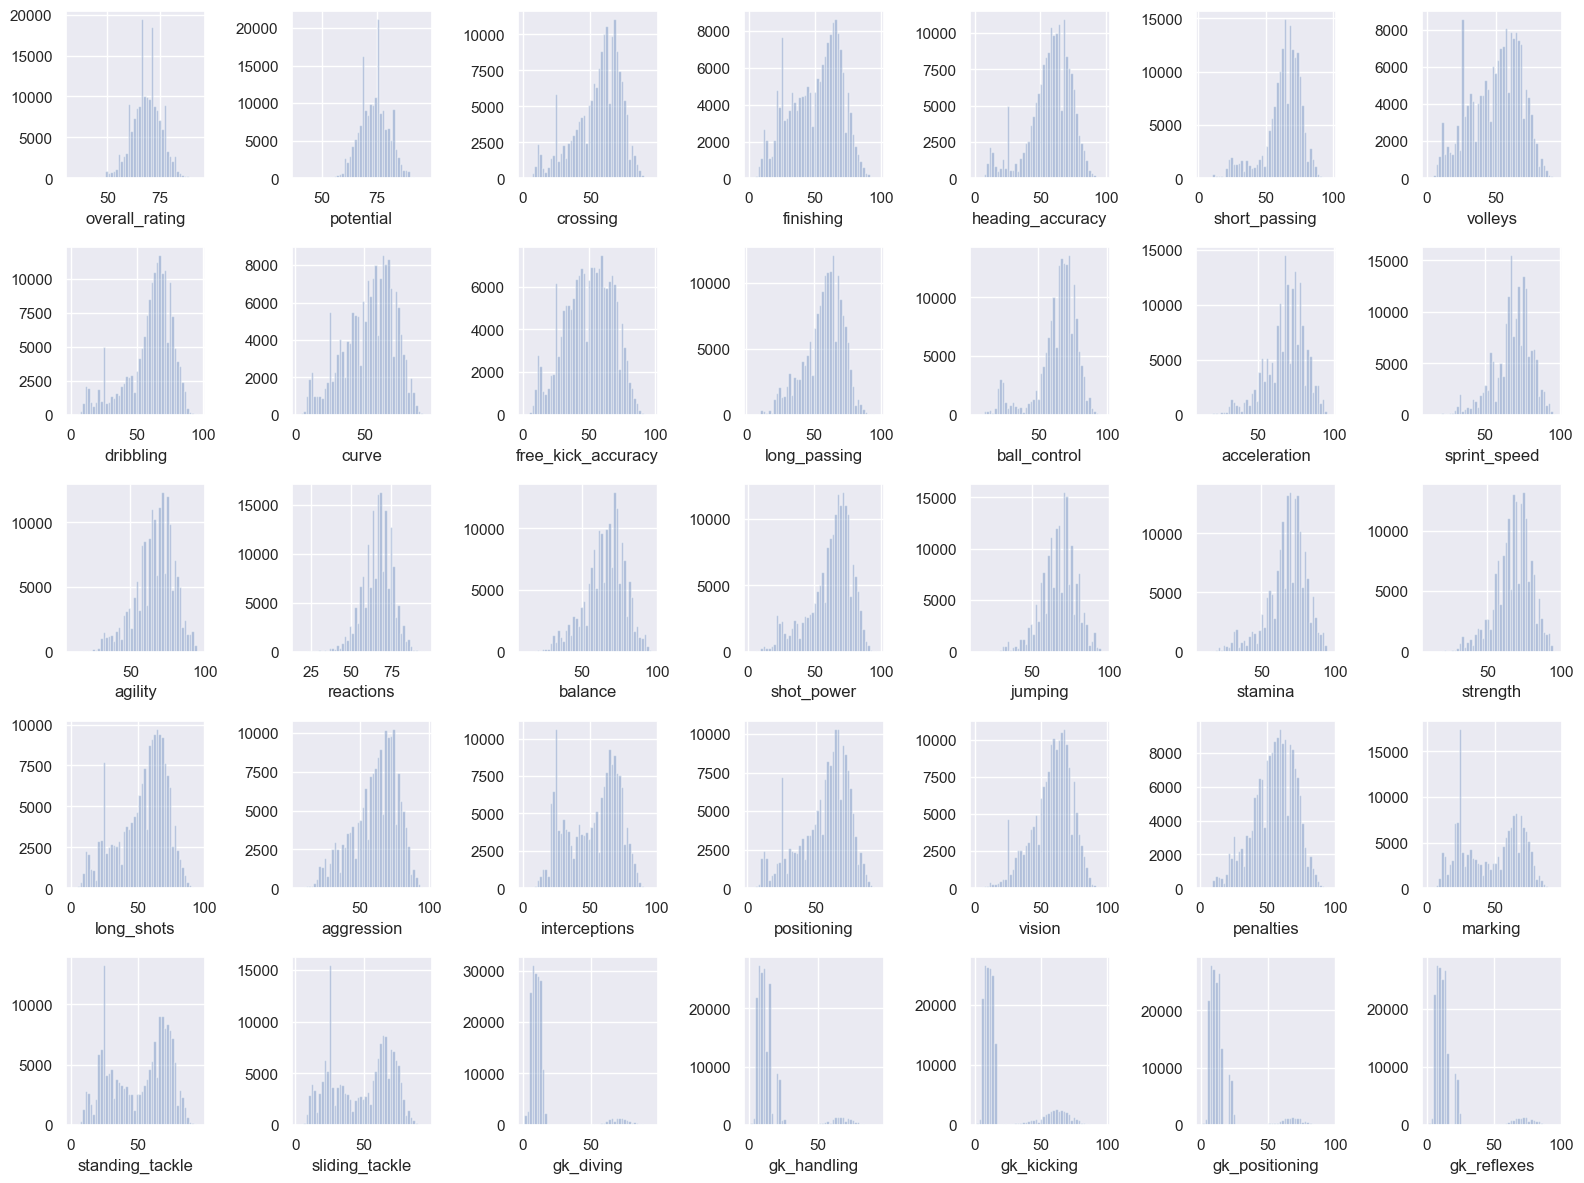

In [102]:
fig5, ax5 = plt.subplots(nrows=5,ncols=7)
fig5.set_size_inches(16,12)
for i,j in enumerate(player_att_table_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.distplot(pat.loc[:,j],kde = False,hist = True, ax = ax5[int(i/7)][i%7])
fig5.tight_layout()

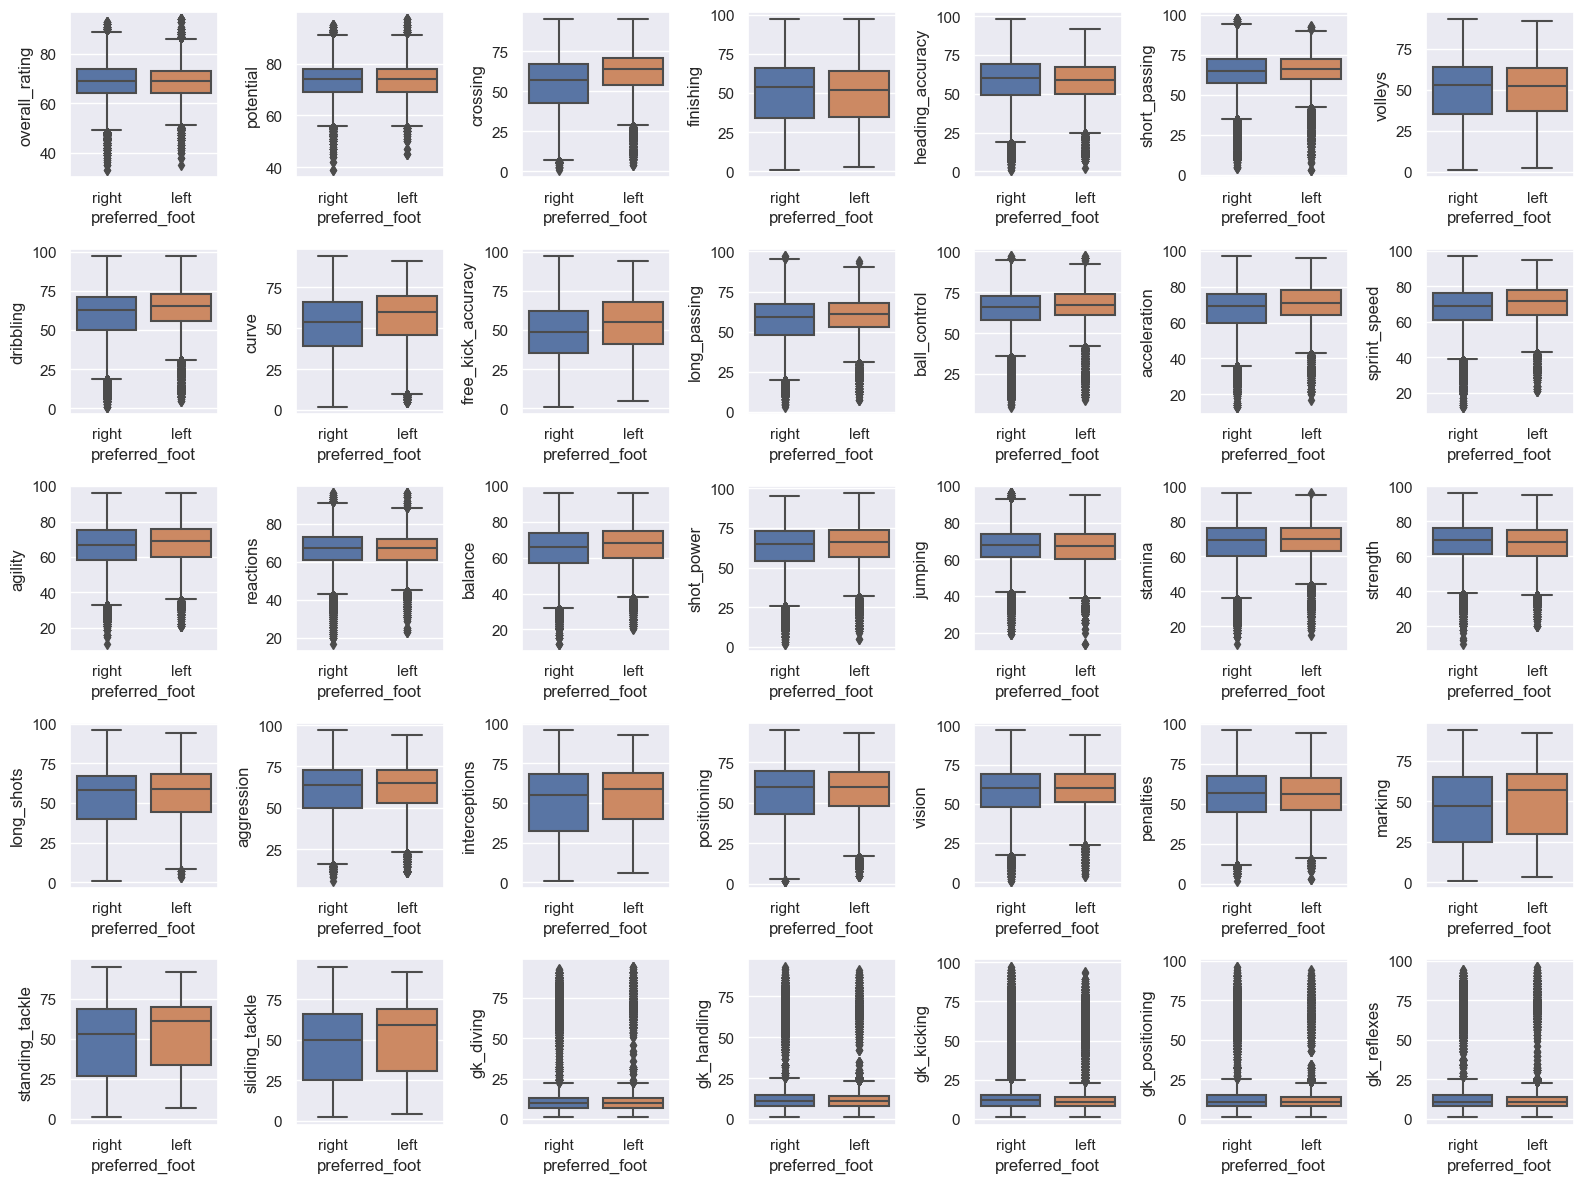

In [103]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)
for i,j in enumerate(player_att_table_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "preferred_foot", y = j, data= pat, ax = ax6[int(i/7)][i%7])
fig6.tight_layout()

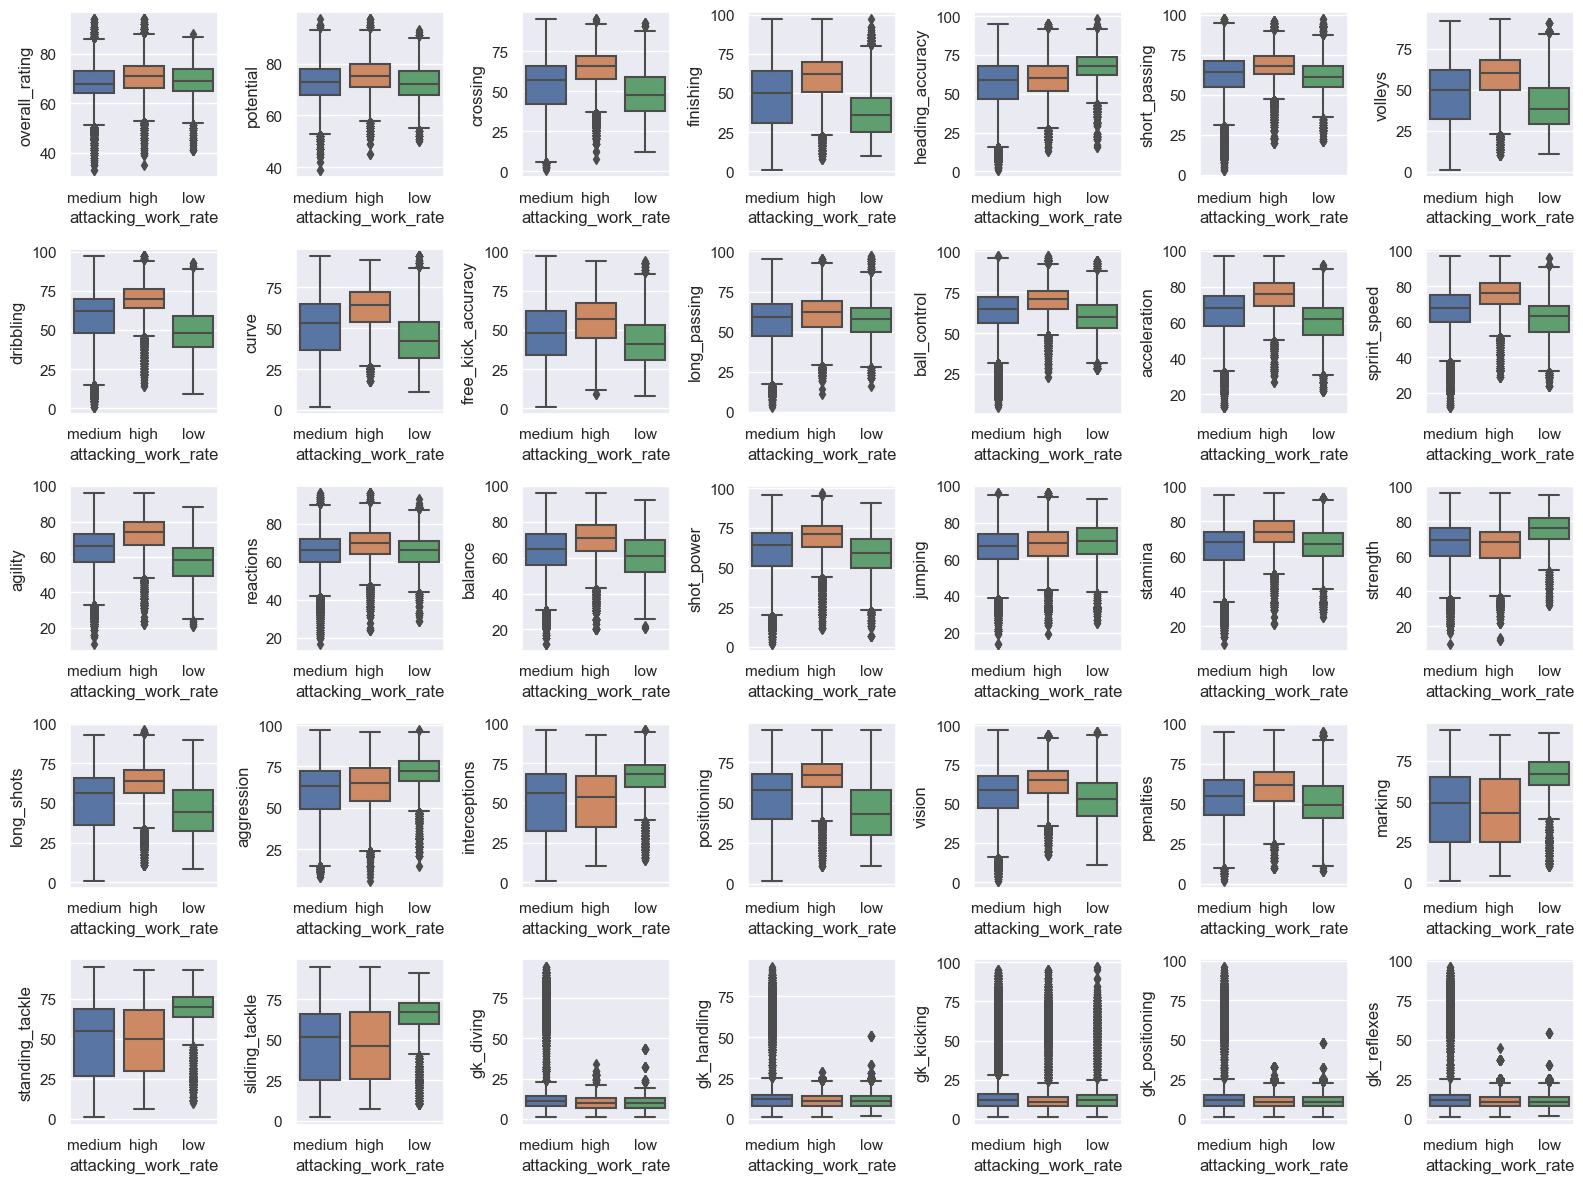

In [104]:
fig7, ax7 = plt.subplots(nrows=5,ncols=7)
fig7.set_size_inches(16,12)
for i,j in enumerate(player_att_table_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "attacking_work_rate", y = j, data= pat, ax = ax7[int(i/7)][i%7])
fig7.tight_layout() 

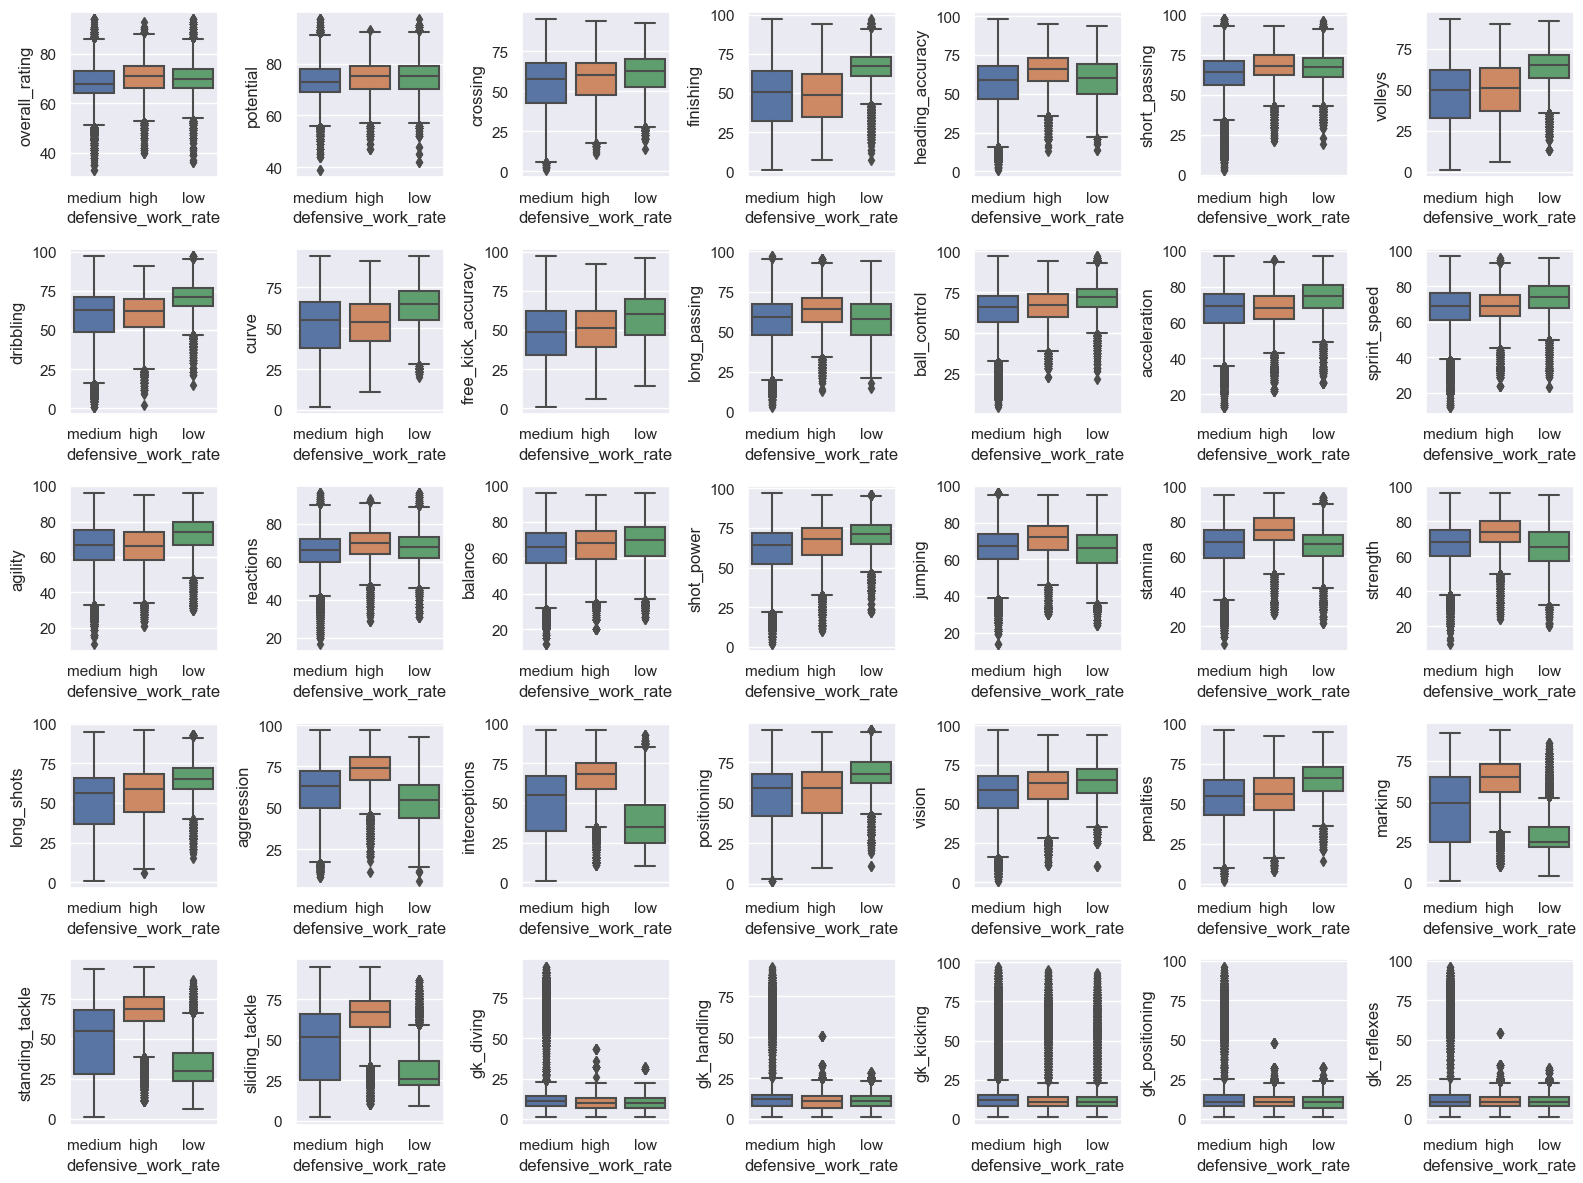

In [105]:
fig8, ax8 = plt.subplots(nrows=5,ncols=7)
fig8.set_size_inches(16,12)
for i,j in enumerate(player_att_table_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "defensive_work_rate", y = j, data= pat, ax = ax8[int(i/7)][i%7])
fig8.tight_layout()

In [106]:
team_table_updated = team_table[~team_table.loc[:,'team_fifa_api_id'].isnull()]

In [108]:
team_att_table_updated1 = team_att_table.drop(['buildUpPlayDribbling'],axis = 1)
tat = team_att_table_updated1.loc[:,team_att_table_updated1.columns.tolist()[3:]]

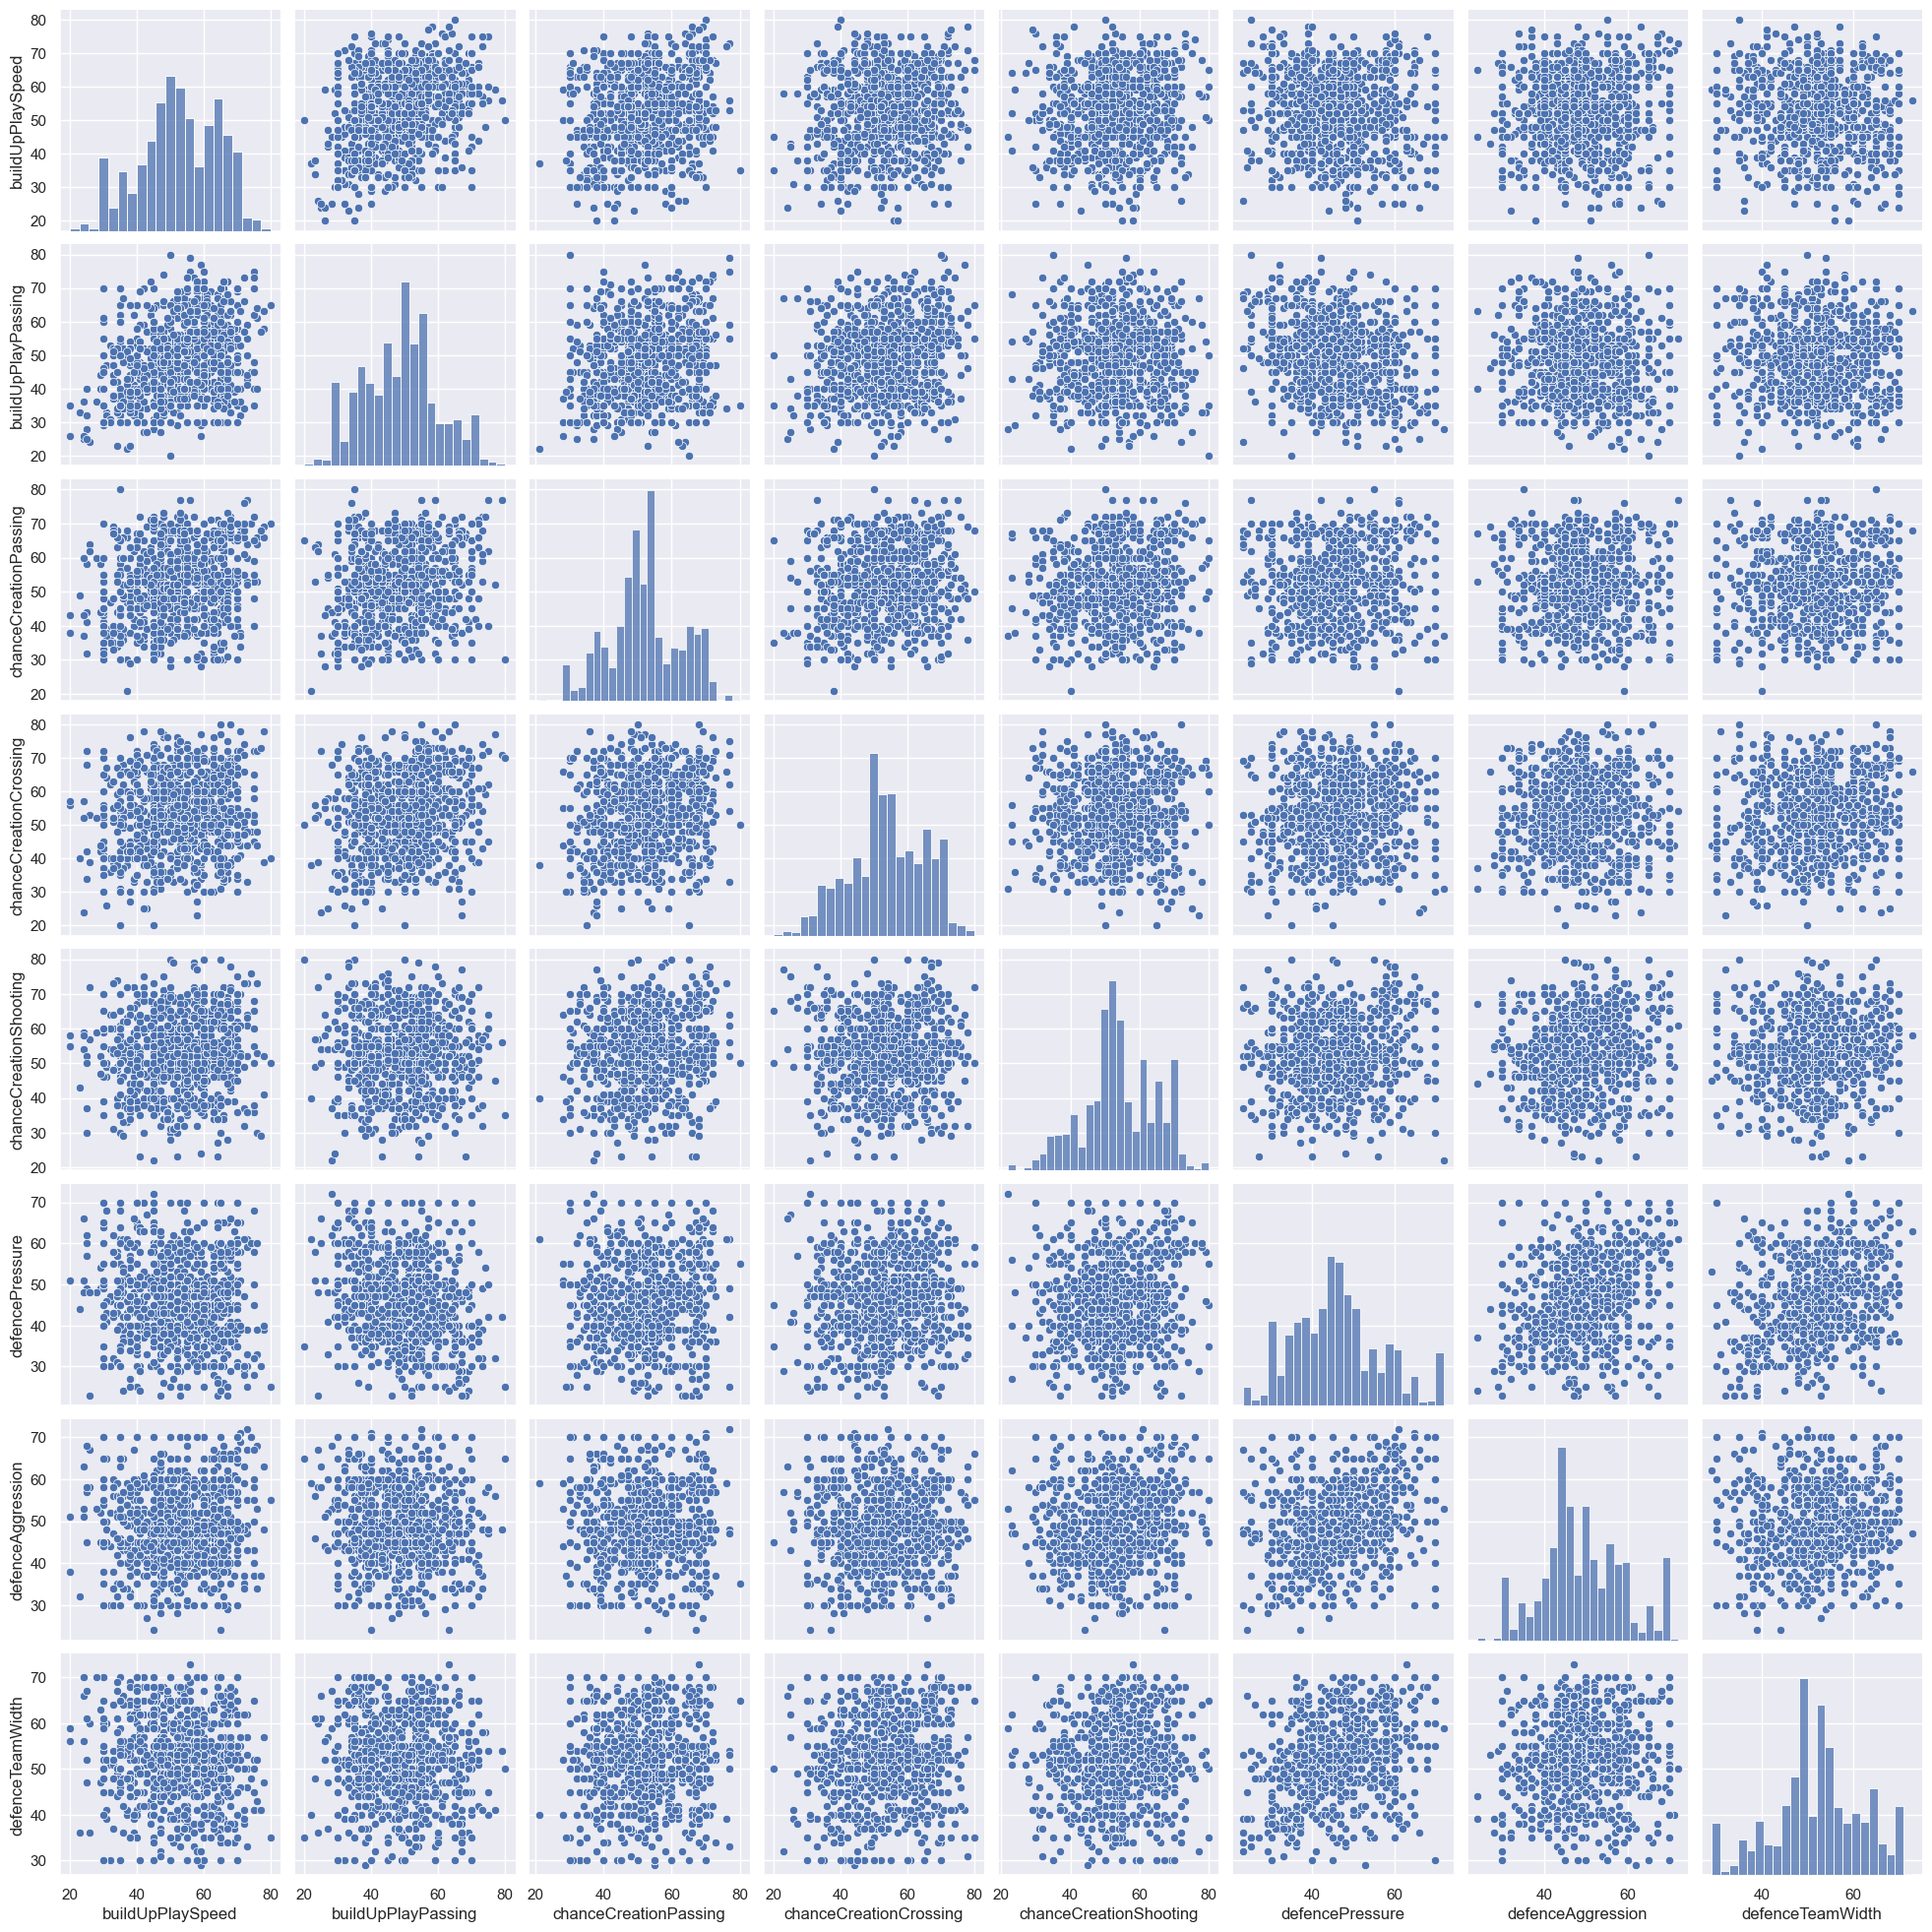

In [109]:
sns.pairplot(tat)

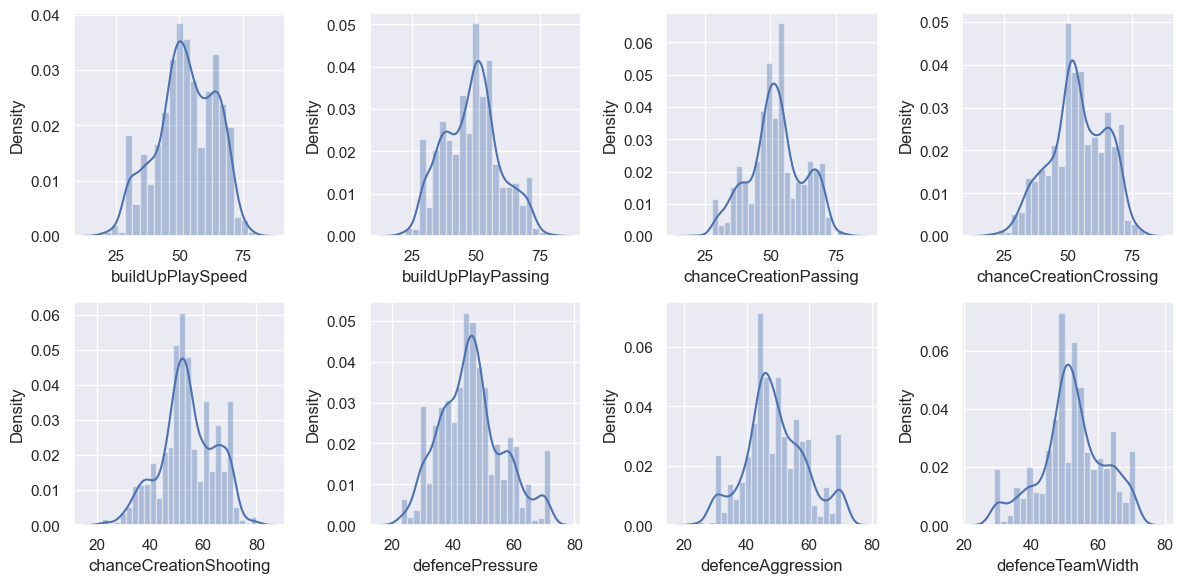

In [110]:
fig9, ax9 = plt.subplots(nrows=2,ncols=4)
fig9.set_size_inches(12,6)
for i,j in enumerate(team_att_table_updated1.select_dtypes(include = ['int64']).columns[3:].tolist()):
    sns.distplot(tat.loc[:,j],kde =True,hist = True, ax = ax9[int(i/4)][i%4])
fig9.tight_layout()

<Axes: >

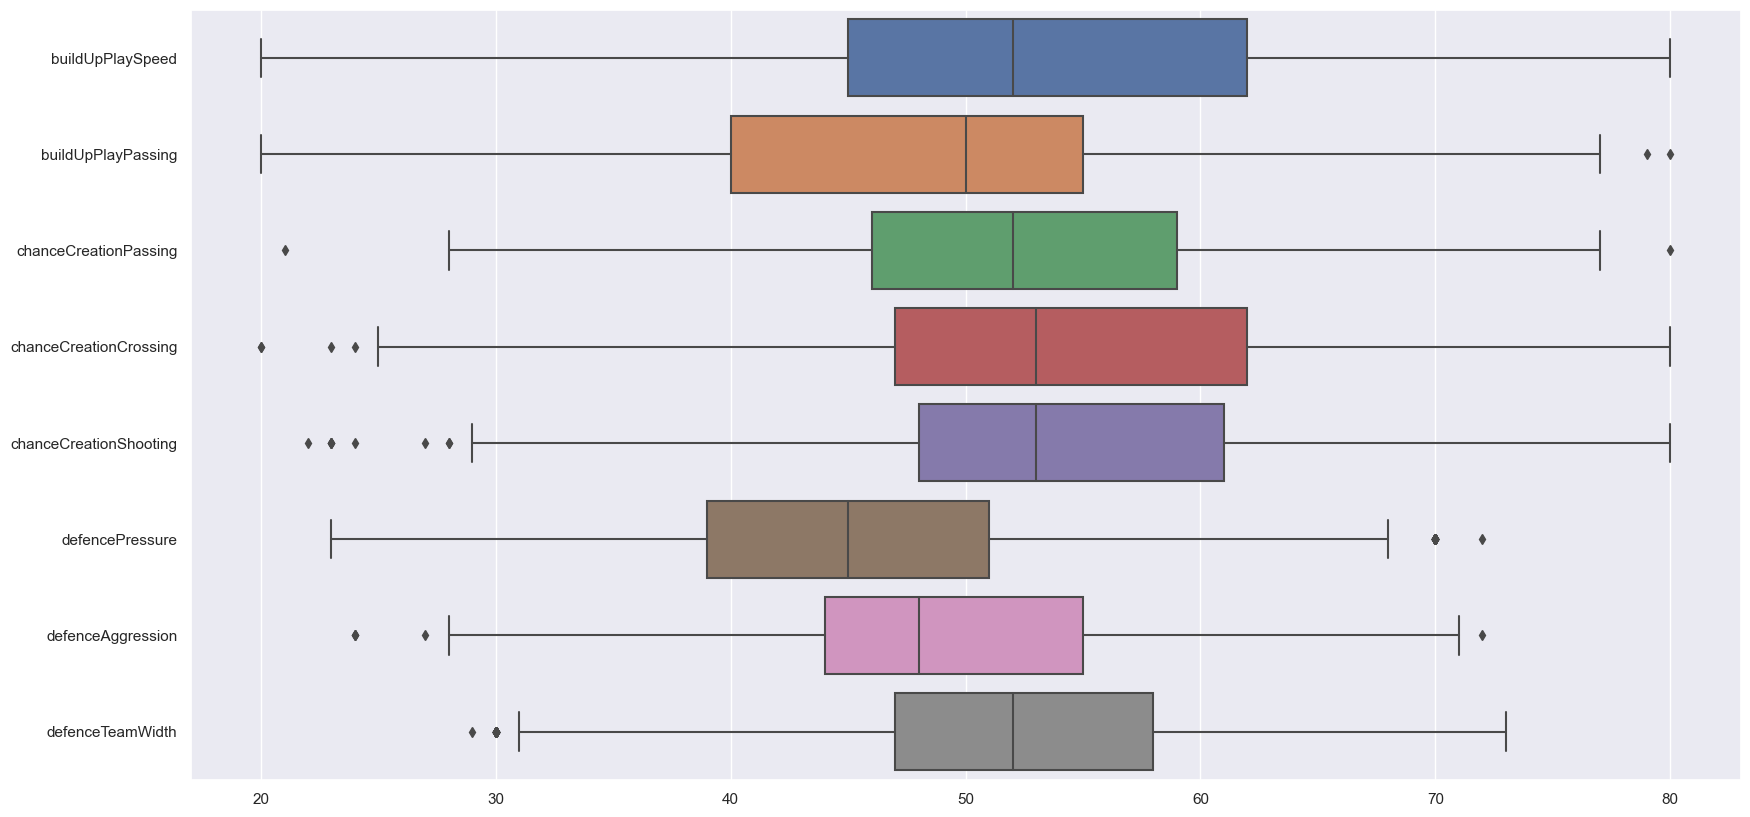

In [111]:
sns.boxplot(data = team_att_table_updated1.select_dtypes(include = ['int64']).iloc[:,3:],\
           orient = 'h')

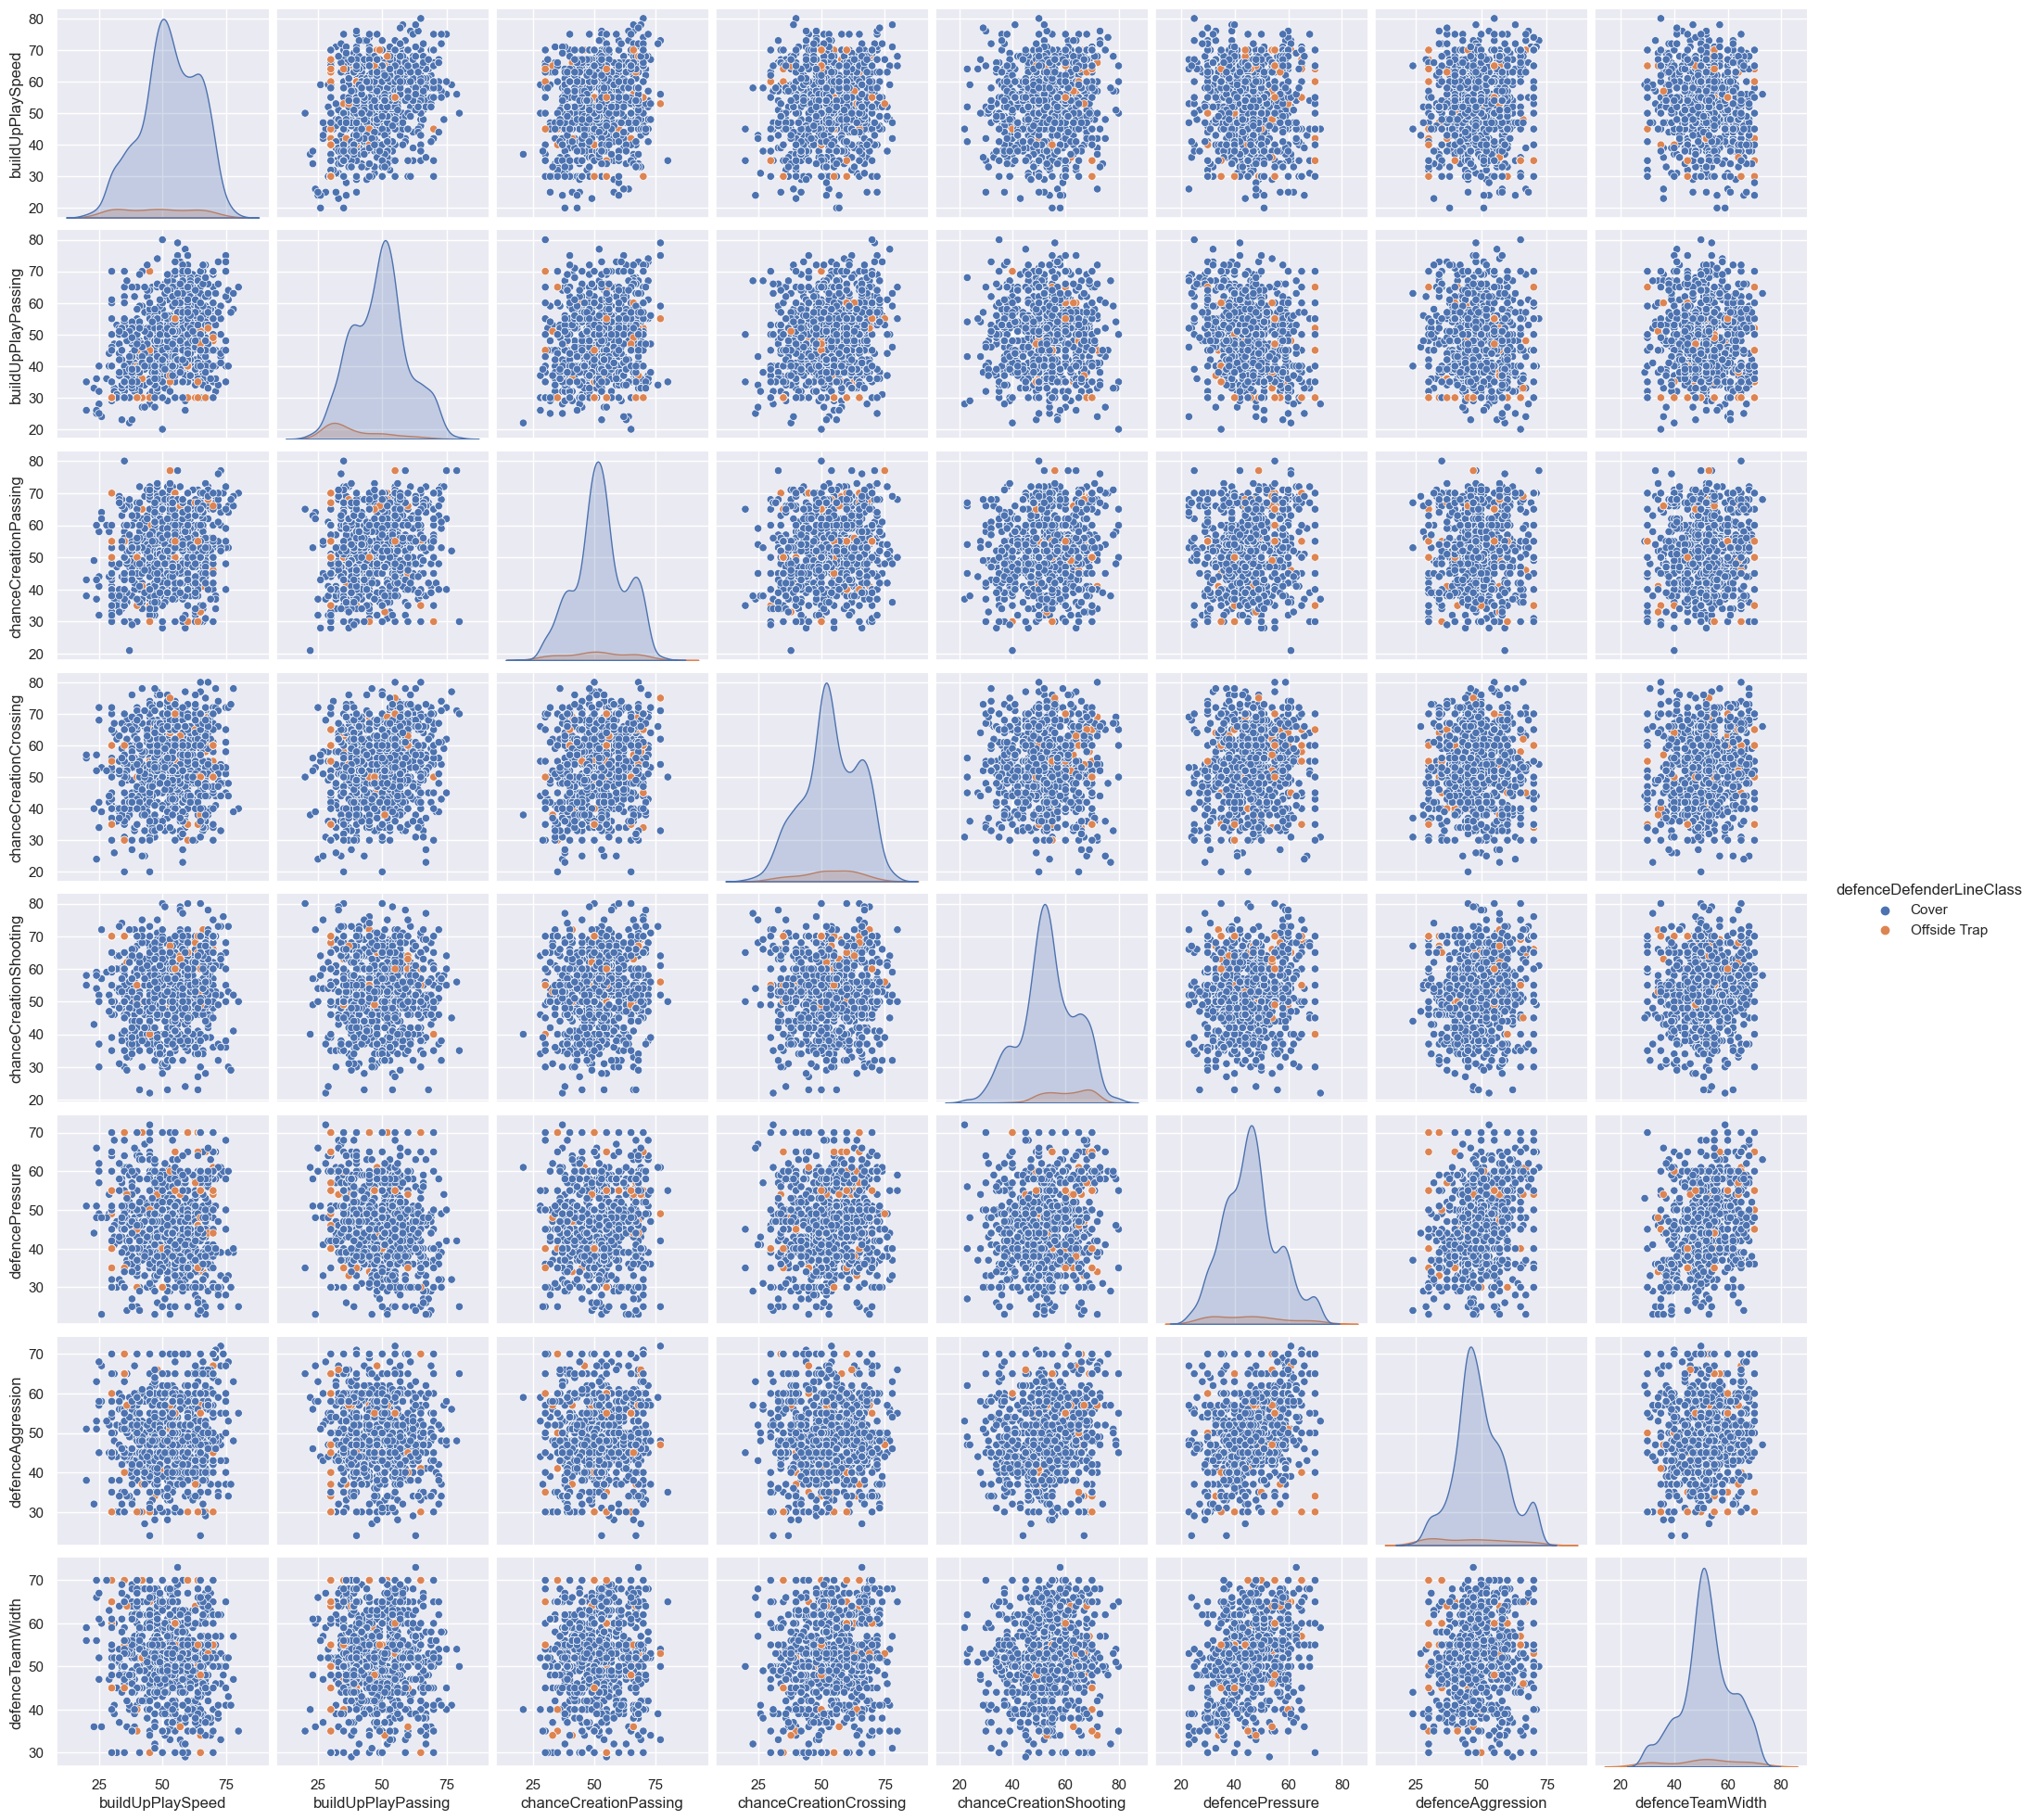

In [115]:
sns.pairplot(tat,hue = tat.select_dtypes(include = ['object']).\
          columns.tolist()[12]) 